In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/fraud_oracle_processed.csv')

In [3]:
# Check if there are missing values
df[df.isna().any(axis=1)]

,Unnamed: 0,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,WeekOfMonthClaimed,Sex,Age,...,AddressChange_Claim,NumberOfCars,Year,BasePolicy,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,MonthClaimed,UnusualDeductible,ClaimsPerAgent


In [4]:
df.head()

,Unnamed: 0,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,WeekOfMonthClaimed,Sex,Age,...,AddressChange_Claim,NumberOfCars,Year,BasePolicy,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,MonthClaimed,UnusualDeductible,ClaimsPerAgent
0,0,Dec,5,Wednesday,Honda,Urban,Tuesday,1,0,21,...,2,3,1994,Liability,False,True,False,1,0,15179
1,1,Jan,3,Wednesday,Honda,Urban,Monday,4,1,34,...,0,1,1994,Collision,False,True,False,1,0,15179
2,2,Oct,5,Friday,Honda,Urban,Thursday,2,1,47,...,0,1,1994,Collision,True,False,False,11,0,15179
3,3,Jun,2,Saturday,Toyota,Rural,Friday,1,1,65,...,0,1,1994,Liability,True,False,False,7,0,15179
4,4,Jan,5,Monday,Honda,Urban,Tuesday,2,0,27,...,0,1,1994,Collision,False,True,False,2,0,15179


# **Data cleaning**


In [5]:
# Remove index column
df = df.iloc[:, 1:]

In [6]:
# Remove one row with DayOfWeekClaimed = 0 and MonthClaimed = 0
df = df.loc[~((df['DayOfWeekClaimed'] == '0') | (df['MonthClaimed'] == '0'))]

In [7]:
# Reorder the columns such that PolicyNumber is first
cols = df.columns.tolist()         # get the current column order
cols.remove('PolicyNumber')         # remove 'PolicyNumber' from its current position
df = df[['PolicyNumber'] + cols]     # reassemble the DataFrame with 'PolicyNumber' as the first column
print("Columns:")
for col in cols:
    print(f"• {col}")   #list of labels

Columns:
• Month
• WeekOfMonth
• DayOfWeek
• Make
• AccidentArea
• DayOfWeekClaimed
• WeekOfMonthClaimed
• Sex
• Age
• Fault
• PolicyType
• VehicleCategory
• VehiclePrice
• FraudFound_P
• RepNumber
• Deductible
• DriverRating
• Days_Policy_Accident
• Days_Policy_Claim
• PastNumberOfClaims
• AgeOfVehicle
• AgeOfPolicyHolder
• PoliceReportFiled
• WitnessPresent
• AgentType
• NumberOfSuppliments
• AddressChange_Claim
• NumberOfCars
• Year
• BasePolicy
• MaritalStatus_Married
• MaritalStatus_Single
• MaritalStatus_Widow
• MonthClaimed
• UnusualDeductible
• ClaimsPerAgent


### Numerical Mapping

In [8]:
# Convert dummy variables to a single MaritalStatus column
df['MaritalStatus'] = df.filter(regex = '^MaritalStatus_').idxmax(axis = 1)
df['MaritalStatus'] = df['MaritalStatus'].str.replace('MaritalStatus_', '')
df.drop(['MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widow'], axis = 1, inplace = True)

In [9]:
# Mappings for numerical df

month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

day_mapping = {
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7
}

area_mapping = {
    'Rural': 0, 'Urban': 1
}

fault_mapping = {
    'Policy Holder': 0, 'Third Party': 1
}

vtype_mapping = {
    'Sedan': 1, 'Sport': 2, 'Utility': 3
}

basepol_mapping = {
    'Collision': 1, 'Liability': 2, 'All Perils': 3
}

ptype_mapping = {}
for vtype, v_val in vtype_mapping.items():
    for basepol, bp_val in basepol_mapping.items():
        key = f'{vtype} - {basepol}'
        ptype_mapping[key] = v_val * 10 + bp_val

mstatus_mapping = {
    'Single': 0, 'Married': 1, 'Widow': 2
}

extra_mappings = {
    'Month': month_mapping,
    'DayOfWeek': day_mapping,
    'DayOfWeekClaimed': day_mapping,
    'AccidentArea': area_mapping,
    'Fault': fault_mapping,
    'VehicleCategory': vtype_mapping,
    'BasePolicy': basepol_mapping,
    'PolicyType': ptype_mapping,
    'MaritalStatus': mstatus_mapping
}

In [10]:
# Convert categorical variables to numerical in numeric df
numeric_df = df.copy()
for col, mapping in extra_mappings.items():
    numeric_df[col] = numeric_df[col].map(mapping)

#print(numeric_df)

In [11]:
# Remove Make(car brand) column as VehiclePrice provides more/same value as car brand and car brand is categorical
numeric_df.drop(['Make'], axis = 1, inplace = True)

In [12]:
# Reordering columns for easier visualization
cols = numeric_df.columns.tolist()         
cols.remove("MonthClaimed")   
cols.remove("WeekOfMonthClaimed")
idx = cols.index("DayOfWeekClaimed")
cols.insert(idx, "WeekOfMonthClaimed") 
cols.insert(idx, "MonthClaimed") 
numeric_df = numeric_df[cols]

### Cleaning of data with Age = 0

In [13]:
import lightgbm as lgb

# use a LightGBM regression model to predict a reasonable Age value for those rows.
age_outliers = (numeric_df['Age'] == 0)
train_df_age = numeric_df[~age_outliers].copy()
X_train_age = train_df_age.drop(columns = ['Age'])
y_train_age = train_df_age['Age']
lgb_train = lgb.Dataset(X_train_age, label = y_train_age)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'seed': 123
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
X_outliers_age = numeric_df.loc[age_outliers].drop(columns=['Age'])
numeric_df.loc[age_outliers, 'Age'] = np.rint(gbm.predict(X_outliers_age)).astype(int)

/var/folders/5h/wvnq36zs6bq65ndzn1gf1jcc0000gn/T/ipykernel_209/2355481326.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FraudFound_P', y='Age', data=numeric_df, palette='Set2')


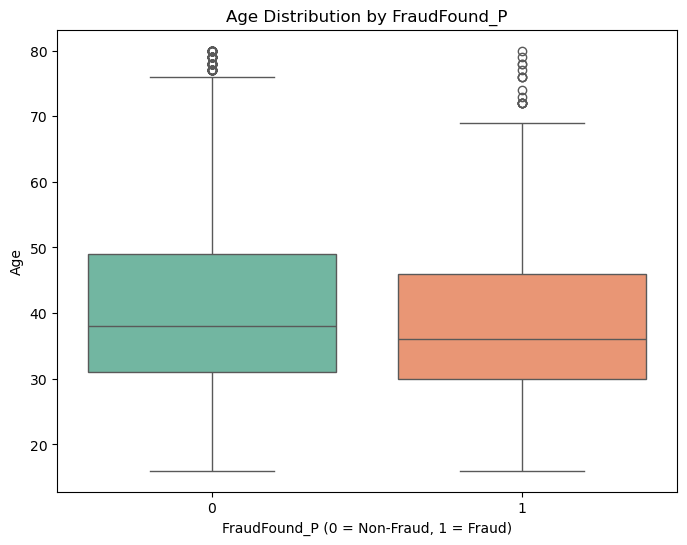

In [14]:
# Distribution of Modified Age
plt.figure(figsize=(8,6))
sns.boxplot(x='FraudFound_P', y='Age', data=numeric_df, palette='Set2')
plt.title('Age Distribution by FraudFound_P')
plt.xlabel('FraudFound_P (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Age')
plt.show()

# **Hypothesis Testing**

In [15]:
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
warnings.filterwarnings('ignore', category = UserWarning)

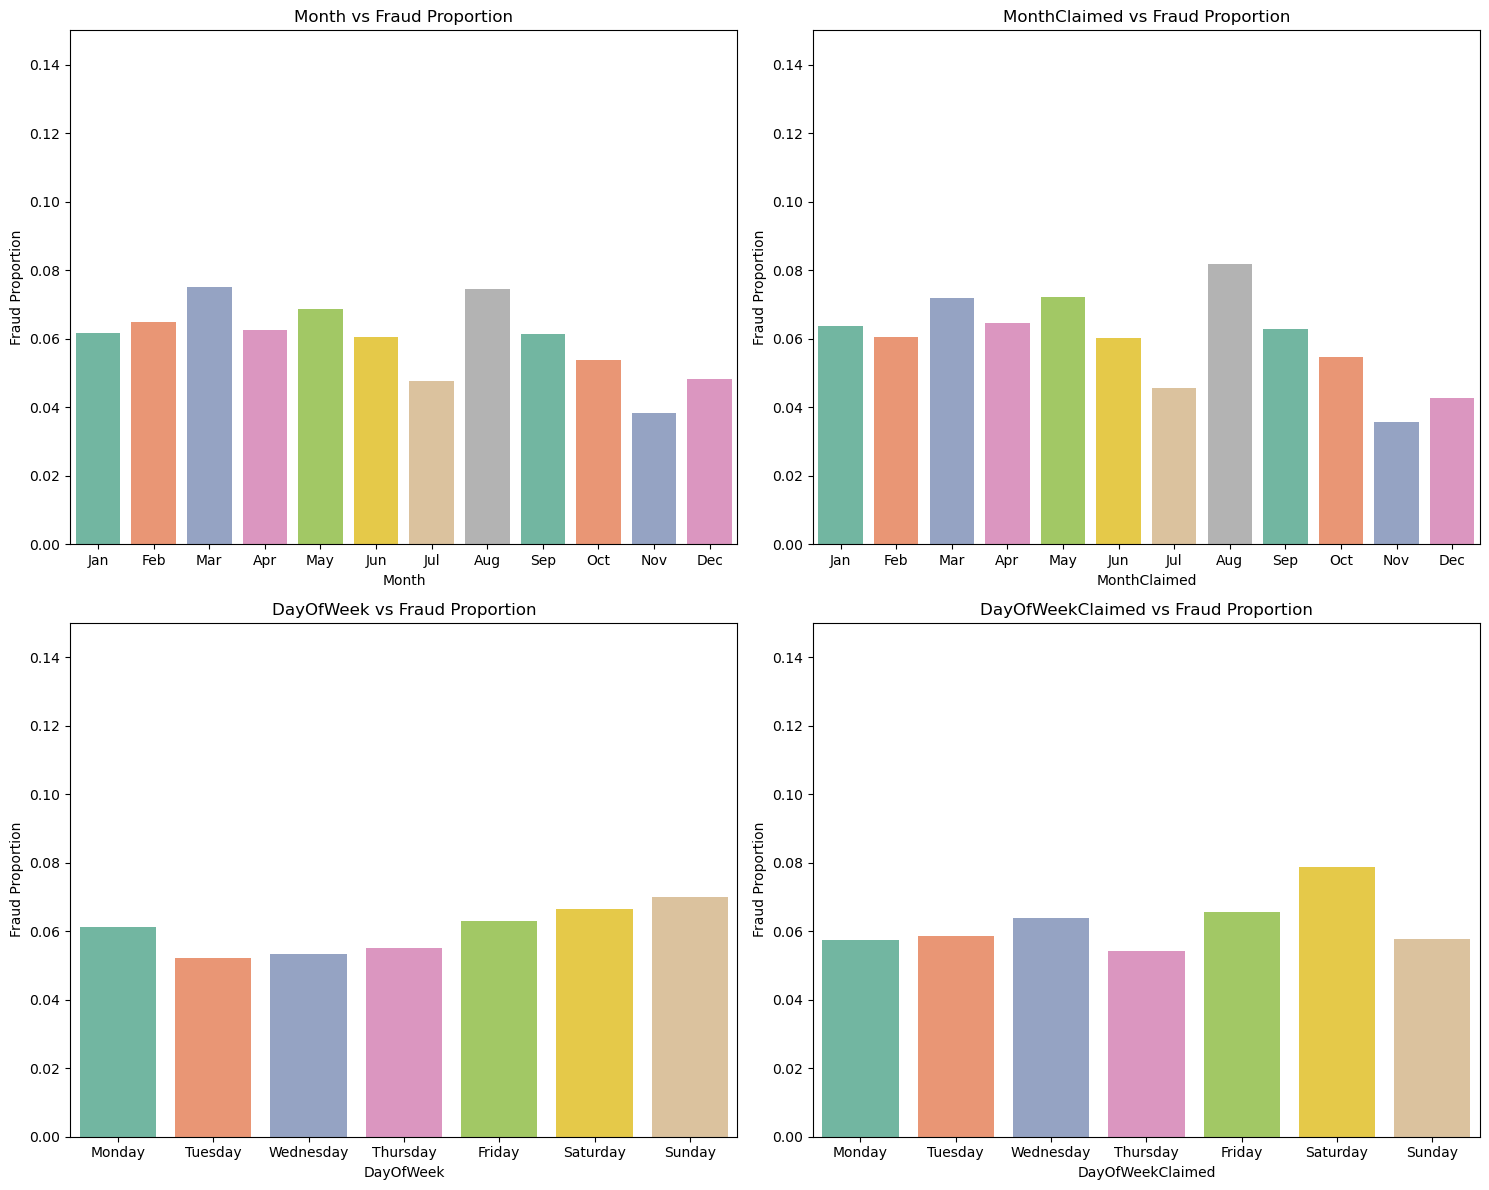

In [16]:
# Hypothesis 1: Temporal Variables
## Fraudulent claims are more likely to occur during specific periods, such as Mondays or end-of-year.

temporal_vars = ['Month', 'MonthClaimed', 'DayOfWeek', 'DayOfWeekClaimed']

# Create a 2x2 grid for subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs = axs.flatten()
month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
day_mapping = {
    1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'
}
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

temp_df = numeric_df.copy() 
order = None
    
for i, var in enumerate(temporal_vars):
    # Group data to compute the proportion of fraud (FraudFound_P == 1)
    if var == 'Month' or var == 'MonthClaimed':
        temp_df[var] = temp_df[var].replace(month_mapping)
    else:
        temp_df[var] = temp_df[var].replace(day_mapping)
    fraud_prop = temp_df.groupby(var)['FraudFound_P'].mean().reset_index()
    
    ax = axs[i]
    if var == 'Month' or var == 'MonthClaimed':
        sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax, order = month_order)
    else:
        sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax, order = day_order)
    
    # Remove bar outlines by setting linewidth to 0 for each patch
    for patch in ax.patches:
        patch.set_linewidth(0)
    
    ax.set_title(f'{var} vs Fraud Proportion')
    ax.set_xlabel(var)
    ax.set_ylabel('Fraud Proportion')  # explicitly label the y-axis (0 to 1)
    ax.set_ylim(0, 0.15)  # since proportions range from 0 to 1  

plt.tight_layout()
plt.show()

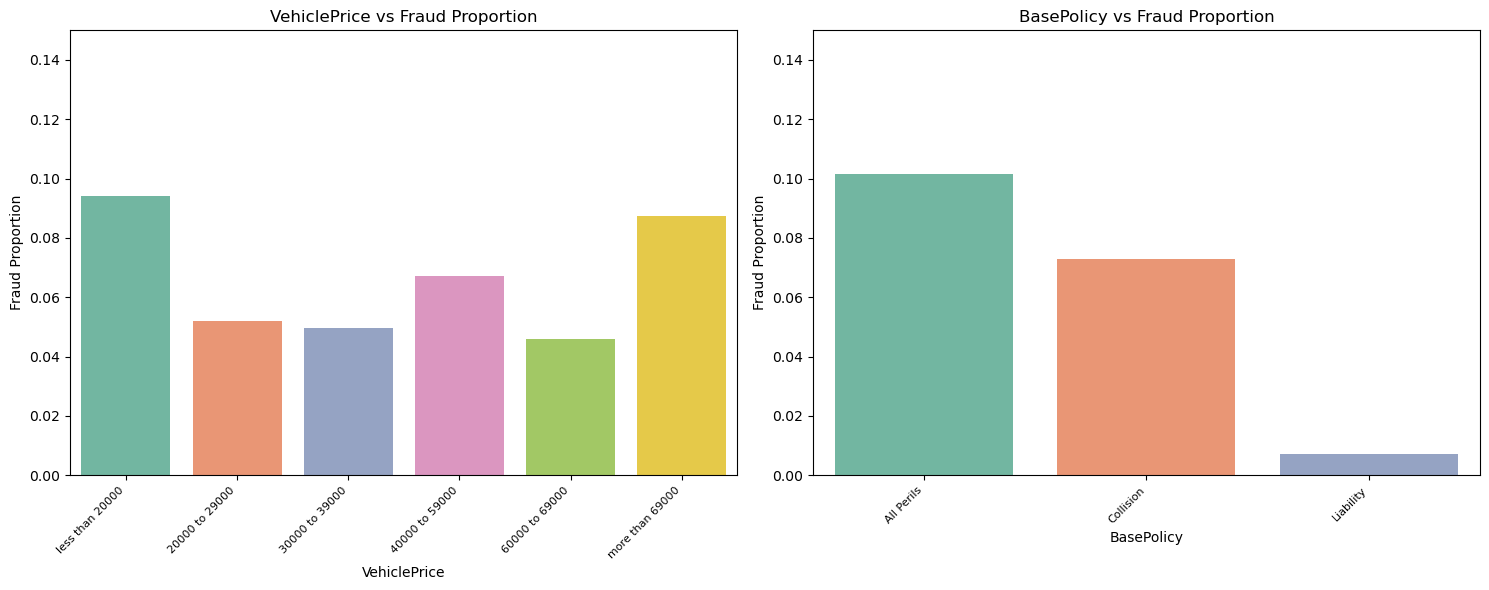

In [17]:
# Hypothesis 2: Policy and Vehicle Information
## High-value vehicles with minimal coverage (e.g., Collision only) are more susceptible to fraudulent claims

polval_vars = ['VehiclePrice', 'BasePolicy']

# Create a 1x2 grid for subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs = axs.flatten()

temp_df = df.copy() 
order = None
vehicle_price_mapping = {0: 'less than 20000', 1: '20000 to 29000', 2: '30000 to 39000', 
                         3: '40000 to 59000', 4: '60000 to 69000', 5: 'more than 69000'}
vehicle_price_order = ['less than 20000', '20000 to 29000', '30000 to 39000', 
                       '40000 to 59000', '60000 to 69000', 'more than 69000']
    
for i, var in enumerate(polval_vars):
    # Group data to compute the proportion of fraud (FraudFound_P == 1)
    if var == 'VehiclePrice':
        temp_df[var] = temp_df[var].replace(vehicle_price_mapping)
        
    fraud_prop = temp_df.groupby(var)['FraudFound_P'].mean().reset_index()
    
    ax = axs[i]
    if var == 'VehiclePrice':
        sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax, order = vehicle_price_order)
    else:
        sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax)

    
    # Remove bar outlines by setting linewidth to 0 for each patch
    for patch in ax.patches:
        patch.set_linewidth(0)
    
    ax.set_title(f'{var} vs Fraud Proportion')
    ax.set_xlabel(var)
    ax.set_ylabel('Fraud Proportion')  # explicitly label the y-axis (0 to 1)
    ax.set_ylim(0, 0.15)  # since proportions range from 0 to 1  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

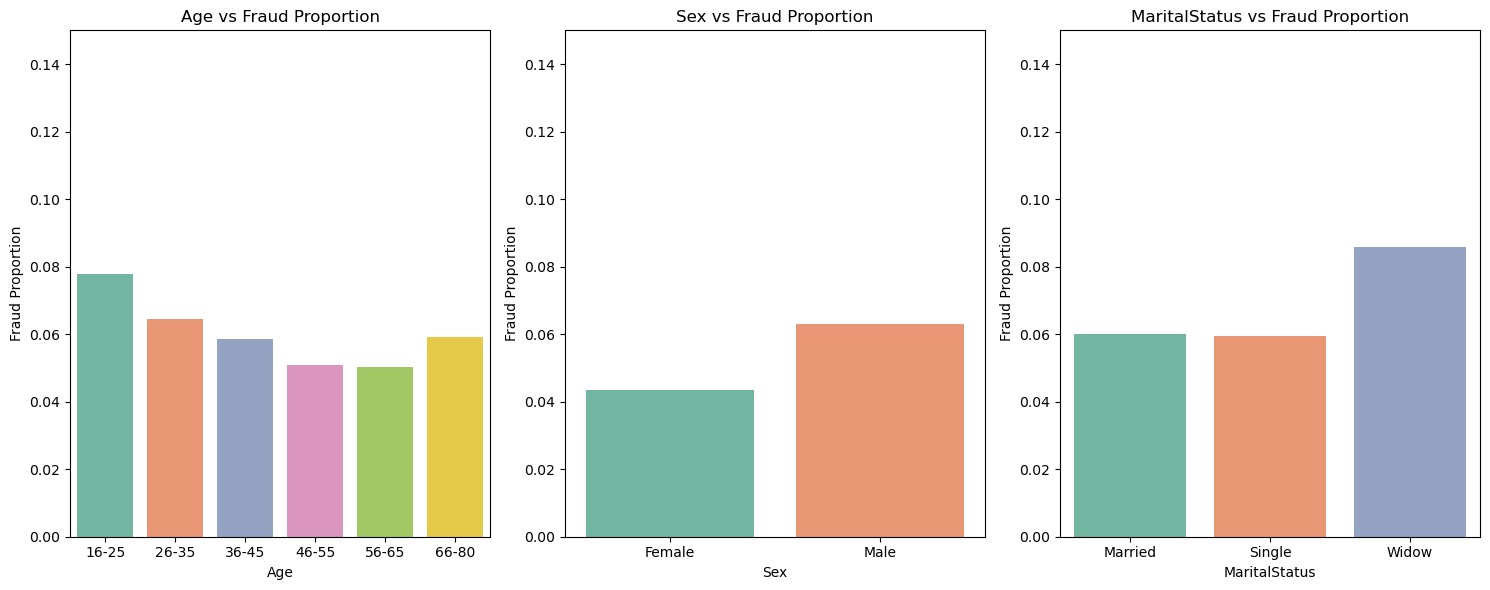

In [18]:
# Hypothesis 3: Customer Demographics
## Young male policyholders who are single are more likely to commit fraud.

customer_demo = ['Age', 'Sex', 'MaritalStatus']

# Create a 1x2 grid for subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs = axs.flatten()

temp_df = numeric_df.copy() 
order = None

sex_mapping = {
    0: 'Female', 1: 'Male'
}
mstatus_mapping = {
    0: 'Single', 1: 'Married', 2:'Widow'
}

    
for i, var in enumerate(customer_demo):
    # Group data to compute the proportion of fraud (FraudFound_P == 1)
    if var == 'Sex':
        temp_df[var] = temp_df[var].replace(sex_mapping)
    elif var == 'Age':
        bins = [16, 26, 36, 46, 56, 66, 81]
        labels_age = ["16-25", "26-35", "36-45", "46-55", "56-65", "66-80"]
        temp_df[var] = pd.cut(temp_df[var], bins=bins, labels=labels_age, right=False)
    else:
        temp_df[var] = temp_df[var].replace(mstatus_mapping)
        
    fraud_prop = temp_df.groupby(var)['FraudFound_P'].mean().reset_index()
    
    ax = axs[i]
    sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax)

    
    # Remove bar outlines by setting linewidth to 0 for each patch
    for patch in ax.patches:
        patch.set_linewidth(0)
    
    ax.set_title(f'{var} vs Fraud Proportion')
    ax.set_xlabel(var)
    ax.set_ylabel('Fraud Proportion')  # explicitly label the y-axis (0 to 1)
    ax.set_ylim(0, 0.15)  # since proportions range from 0 to 1  
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

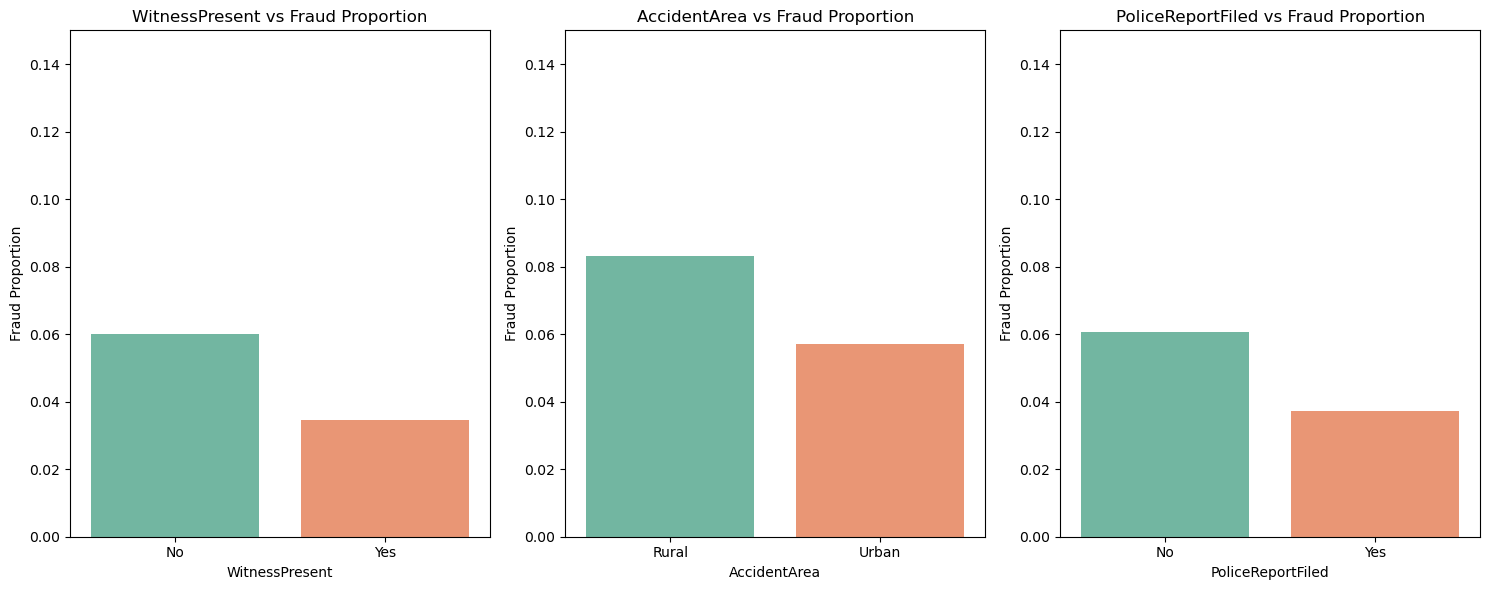

In [19]:
# Hypothesis 4: Accident Circumstances
## Accidents in urban areas with no witnesses are more likely to result in fraudulent claims.

accident_circumstance = ['WitnessPresent', 'AccidentArea', 'PoliceReportFiled']

# Create a 1x2 grid for subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs = axs.flatten()

temp_df = df.copy() 
order = None

binary_mapping = {
    0: 'No', 1: 'Yes'
}
    
for i, var in enumerate(accident_circumstance):
    # Group data to compute the proportion of fraud (FraudFound_P == 1)
    if var == 'WitnessPresent' or 'PoliceReportFiled':
        temp_df[var] = temp_df[var].replace(binary_mapping)

        
    fraud_prop = temp_df.groupby(var)['FraudFound_P'].mean().reset_index()
    
    ax = axs[i]
    sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax)

    
    # Remove bar outlines by setting linewidth to 0 for each patch
    for patch in ax.patches:
        patch.set_linewidth(0)
    
    ax.set_title(f'{var} vs Fraud Proportion')
    ax.set_xlabel(var)
    ax.set_ylabel('Fraud Proportion')  # explicitly label the y-axis (0 to 1)
    ax.set_ylim(0, 0.15)  # since proportions range from 0 to 1  
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

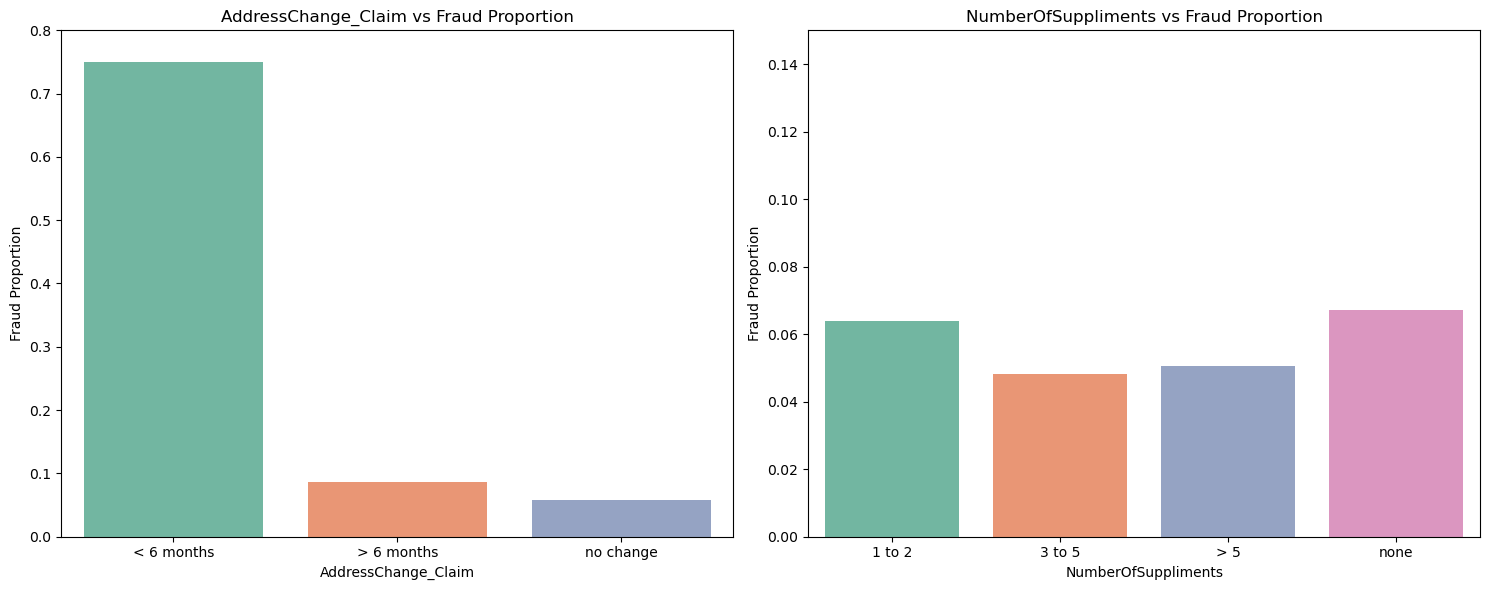

In [20]:
# Hypothesis 5: Claim Filing Process
## Irregular filing or document changes (e.g., address changes, high number of supplements) are associated with fraud.

filing_process = ['AddressChange_Claim', 'NumberOfSuppliments']

# Create a 1x2 grid for subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs = axs.flatten()

temp_df = df.copy() 
order = None

supp_mapping = {
    0: 'none', 1: '1 to 2', 3: '3 to 5', 5: '> 5'
}
ac_mapping = {
    0: 'no change', 1: '< 6 months', 2: '> 6 months', 3: '> 6 months', 4: '> 6 months'
}

    
for i, var in enumerate(filing_process):
    # Group data to compute the proportion of fraud (FraudFound_P == 1)
    if var == 'NumberOfSuppliments':
        temp_df[var] = temp_df[var].replace(supp_mapping)
    else:
        temp_df[var] = temp_df[var].replace(ac_mapping)

        
    fraud_prop = temp_df.groupby(var)['FraudFound_P'].mean().reset_index()
    
    ax = axs[i]
    sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax)

    
    # Remove bar outlines by setting linewidth to 0 for each patch
    for patch in ax.patches:
        patch.set_linewidth(0)
    
    ax.set_title(f'{var} vs Fraud Proportion')
    ax.set_xlabel(var)
    ax.set_ylabel('Fraud Proportion')  # explicitly label the y-axis (0 to 1)
    if var == 'NumberOfSuppliments':
        ax.set_ylim(0, 0.15)
    else:
        ax.set_ylim(0, 0.8)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

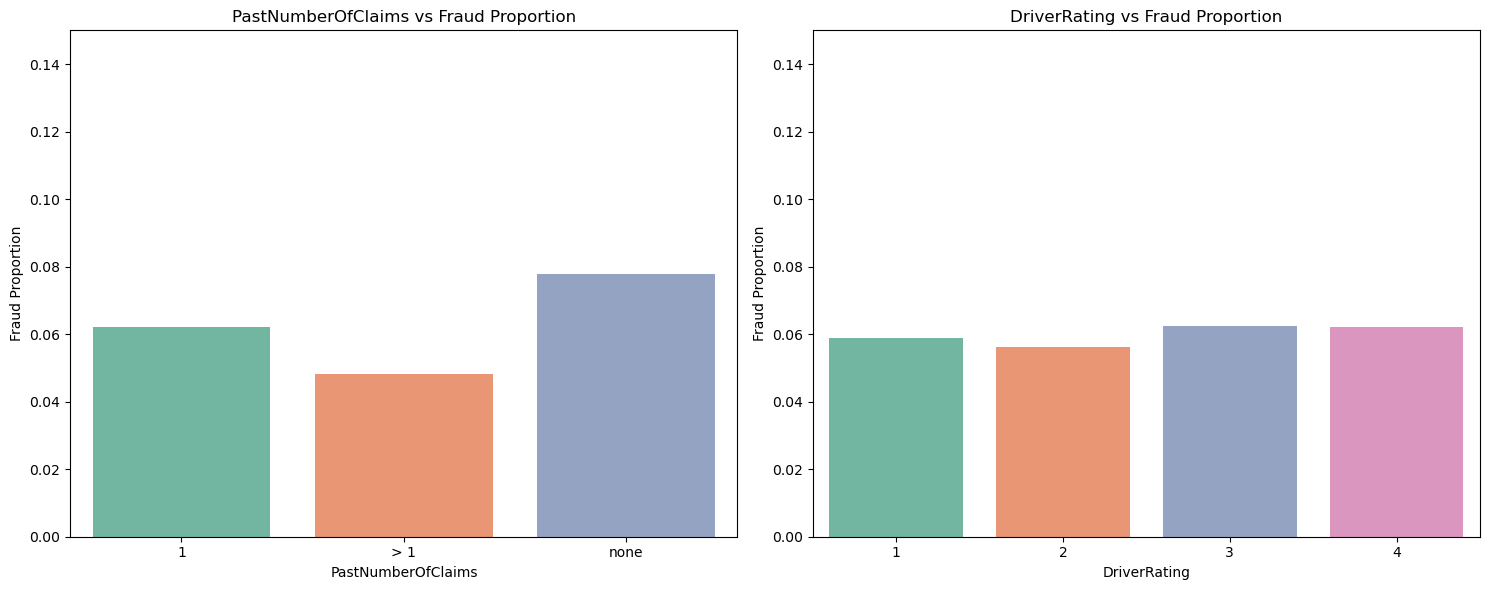

In [21]:
# Hypothesis 6: Historical Behaviour
## Multiple past claims and low driver ratings correlate strongly with higher fraud rates.

hist_behaviour = ['PastNumberOfClaims', 'DriverRating']

# Create a 1x2 grid for subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs = axs.flatten()

temp_df = df.copy() 
order = None

pnoc_mapping = {
    0: 'none', 1: 1, 2: '> 1', 3: '> 1'
}
    
for i, var in enumerate(hist_behaviour):
    # Group data to compute the proportion of fraud (FraudFound_P == 1)
    if var == 'PastNumberOfClaims':
        temp_df[var] = temp_df[var].replace(pnoc_mapping)

        
    fraud_prop = temp_df.groupby(var)['FraudFound_P'].mean().reset_index()
    
    ax = axs[i]
    sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax)

    
    # Remove bar outlines by setting linewidth to 0 for each patch
    for patch in ax.patches:
        patch.set_linewidth(0)
    
    ax.set_title(f'{var} vs Fraud Proportion')
    ax.set_xlabel(var)
    ax.set_ylabel('Fraud Proportion')  # explicitly label the y-axis (0 to 1)
    ax.set_ylim(0, 0.15)  # since proportions range from 0 to 1  
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

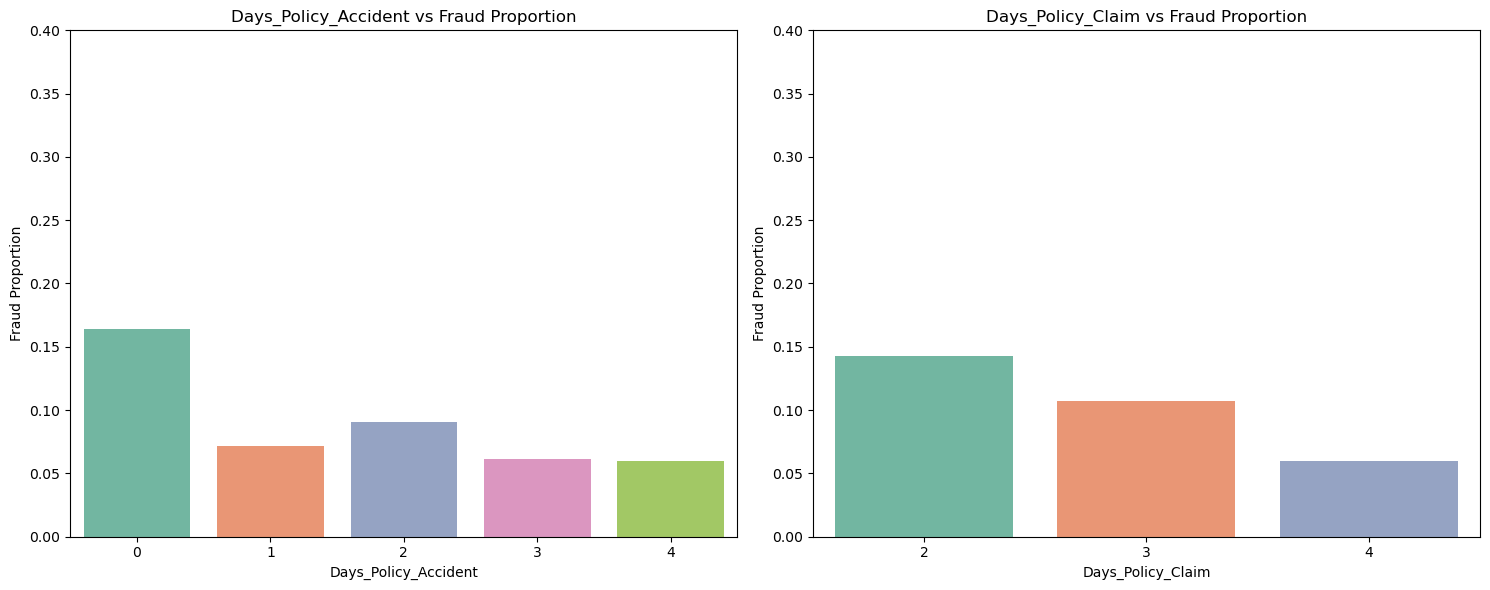

In [22]:
# Hypothesis 7: Time Gaps and Delays
## Extremely short or long periods between 
## 1) policy issuance and accident 
## 2) accident and claim filings
## are red flags for fraudulent claims.

delays = ['Days_Policy_Accident', 'Days_Policy_Claim']

# Create a 1x2 grid for subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs = axs.flatten()

temp_df = numeric_df.copy() 
order = None

# pnoc_mapping = {
#     0: 'none', 1: 1, 2: '> 1', 3: '> 1'
# }
    
for i, var in enumerate(delays):
    # Group data to compute the proportion of fraud (FraudFound_P == 1)
    # if var == 'PastNumberOfClaims':
    #     temp_df[var] = temp_df[var].replace(pnoc_mapping)

        
    fraud_prop = temp_df.groupby(var)['FraudFound_P'].mean().reset_index()
    
    ax = axs[i]
    sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax)

    
    # Remove bar outlines by setting linewidth to 0 for each patch
    for patch in ax.patches:
        patch.set_linewidth(0)
    
    ax.set_title(f'{var} vs Fraud Proportion')
    ax.set_xlabel(var)
    ax.set_ylabel('Fraud Proportion')  # explicitly label the y-axis (0 to 1)
    ax.set_ylim(0, 0.4)  # since proportions range from 0 to 1  
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

# **Feature Engineering (New features)**

In [23]:
# Feature 1: Price-to-Age Ratio (to flag potentially overinsured vehicles)
numeric_df['PriceToAgeRatio'] = np.log1p((numeric_df['VehiclePrice'] + 1) / (numeric_df['AgeOfVehicle'] + 1))
cutoff = numeric_df['PriceToAgeRatio'].quantile(0.95)
numeric_df['PriceToAgeRatio_Capped'] = np.where(numeric_df['PriceToAgeRatio'] > cutoff, cutoff, numeric_df['PriceToAgeRatio'])

# Feature 2: High-Risk Vehicle Flag (expensive + frequent claims)
numeric_df['HighRiskVehicleFlag'] = np.where(
    (numeric_df['PriceToAgeRatio'] > cutoff) & (numeric_df['PastNumberOfClaims'] > 1),  # Threshold chosen based on EDA below
    1, 0
)

numeric_df[['VehiclePrice', 'AgeOfVehicle', 'PastNumberOfClaims', 'AgeOfPolicyHolder', 'PriceToAgeRatio', 'PriceToAgeRatio_Capped', 'HighRiskVehicleFlag']].head()

,VehiclePrice,AgeOfVehicle,PastNumberOfClaims,AgeOfPolicyHolder,PriceToAgeRatio,PriceToAgeRatio_Capped,HighRiskVehicleFlag
0,5,2,0,28,1.098612,0.693147,0
1,5,5,0,33,0.693147,0.693147,0
2,5,6,1,45,0.619039,0.619039,0
3,1,7,1,58,0.223144,0.223144,0
4,5,4,0,33,0.788457,0.693147,0


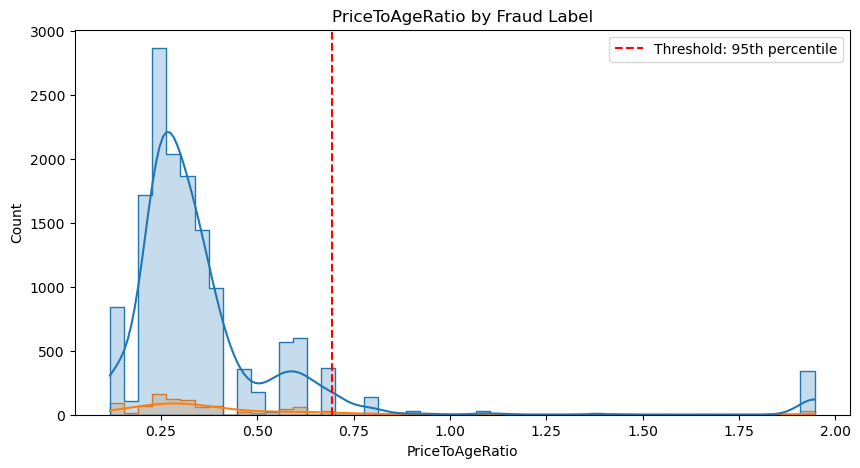

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(data=numeric_df, x='PriceToAgeRatio', hue='FraudFound_P', bins=50, kde=True, element='step')
plt.axvline(cutoff, color='red', linestyle='--', label='Threshold: 95th percentile')
plt.title('PriceToAgeRatio by Fraud Label')
plt.xlabel('PriceToAgeRatio')
plt.ylabel('Count')
plt.legend()
plt.show()

In [25]:
numeric_df['DriverRating'] = numeric_df['DriverRating'].astype(int)

# Feature 3: ClaimAmountRisk where expensive vehicles with low rated drivers might be more prone to fraud
numeric_df['ClaimAmountRisk'] = numeric_df['VehiclePrice'] * numeric_df['DriverRating']

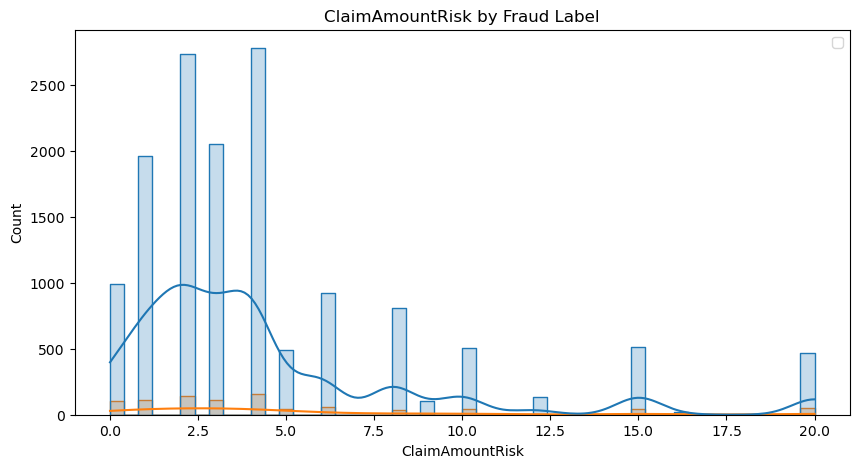

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(data=numeric_df, x='ClaimAmountRisk', hue='FraudFound_P', bins=50, kde=True, element='step')
plt.title('ClaimAmountRisk by Fraud Label')
plt.xlabel('ClaimAmountRisk')
plt.ylabel('Count')
plt.legend()
plt.show()

### Days Between Accident and Claim and Claim Processing Time

In [27]:
## Investigation for days_policy_claim and days_policy_accident
# Mapping below for reference
# 'Days_Policy_Accident': {'none': 0, '1 to 7': 1, '8 to 15': 2, '15 to 30': 3, "more than 30": 4}
# 'Days_Policy_Claim': {'none': 0, '8 to 15': 2, '15 to 30': 3, 'more than 30': 4}

# Days_Policy_Accident is the number of days since the policy was issued until the accident occurred. 
# Days Policy_CLaim is the number of day since the policy was issued until the claim was made.
numeric_df[['Days_Policy_Claim', 'Days_Policy_Accident', 'FraudFound_P']].value_counts()

Days_Policy_Claim  Days_Policy_Accident  FraudFound_P
4                  4                     0               14339
                                         1                 904
                   0                     0                  31
                   3                     0                  31
                   2                     0                  20
3                  2                     0                  17
                   3                     0                  15
2                  2                     0                  13
3                  0                     0                  10
4                  1                     0                   7
3                  1                     0                   6
4                  0                     1                   6
2                  0                     0                   5
3                  2                     1                   3
2                  0                     1                   2
4

In [28]:
numeric_df[numeric_df['Days_Policy_Claim'] < numeric_df['Days_Policy_Accident']].iloc[:, [0, 1, 2, 3, 5, 6, 7, 14, 18, 19]]
#we can see there are 3 policies where days_policy_claim < days_policy_accident (claim happened before accident which is not plausible) what do we do with these 3 rows?

,PolicyNumber,Month,WeekOfMonth,DayOfWeek,MonthClaimed,WeekOfMonthClaimed,DayOfWeekClaimed,FraudFound_P,Days_Policy_Accident,Days_Policy_Claim
7223,7224,5,1,2,5,1,5,0,4,3
13447,13448,7,2,1,7,2,3,1,4,3
13830,13831,3,2,2,3,2,2,0,4,3


In [29]:
# Replace all 0 in Days_Policy_Accident to 1 as the categories none and '1 to 7' should be grouped together when calculating DaysBetween
numeric_df['Days_Policy_Accident'] = numeric_df['Days_Policy_Accident'].replace(0, 1)

# Create a column called DaysBetween to get the number of days between accident and claim 
numeric_df['DaysBetween'] = numeric_df['Days_Policy_Claim'] - numeric_df['Days_Policy_Accident'] + 1
numeric_df['DaysBetween'].unique()
# 'DaysBetween: {'less than 0 (weird)': 0, '0 to 7': 1, '8 to 15': 2, '16-30': 3, 'More than 30': 4}'

array([1, 2, 4, 3, 0])

In [30]:
# Create a column called ClaimProcessingTime to get the number of days between claim made and processed
# Compute a rough day-of-year approximation for accident and claim dates.
numeric_df['claim_day'] = (numeric_df['Month'] - 1) * 30 + (numeric_df['WeekOfMonth'] - 1) * 7 + numeric_df['DayOfWeek']
numeric_df['processed_day'] = (numeric_df['MonthClaimed'] - 1) * 30 + (numeric_df['WeekOfMonthClaimed'] - 1) * 7 + numeric_df['DayOfWeekClaimed']
numeric_df['ClaimProcessingTime'] = numeric_df['processed_day'] - numeric_df['claim_day'] 
numeric_df['ClaimProcessingTime'] = numeric_df['ClaimProcessingTime'] + 365
numeric_df.drop(['claim_day', 'processed_day'], axis = 1, inplace = True)

print(numeric_df['ClaimProcessingTime'])
numeric_df[numeric_df['ClaimProcessingTime'] > 0]

0          6
1        370
2        373
3        387
4        375
        ... 
15415    369
15416    368
15417    368
15418    375
15419    373
Name: ClaimProcessingTime, Length: 15419, dtype: int64


,PolicyNumber,Month,WeekOfMonth,DayOfWeek,AccidentArea,MonthClaimed,WeekOfMonthClaimed,DayOfWeekClaimed,Sex,Age,...,BasePolicy,UnusualDeductible,ClaimsPerAgent,MaritalStatus,PriceToAgeRatio,PriceToAgeRatio_Capped,HighRiskVehicleFlag,ClaimAmountRisk,DaysBetween,ClaimProcessingTime
0,1,12,5,3,1,1,1,2,0,21,...,2,0,15179,0,1.098612,0.693147,0,5,1,6
1,2,1,3,3,1,1,4,1,1,34,...,1,0,15179,0,0.693147,0.693147,0,20,1,370
2,3,10,5,5,1,11,2,4,1,47,...,1,0,15179,1,0.619039,0.619039,0,15,1,373
3,4,6,2,6,0,7,1,5,1,65,...,2,0,15179,1,0.223144,0.223144,0,2,1,387
4,5,1,5,1,1,2,2,2,0,27,...,1,0,15179,0,0.788457,0.693147,0,5,1,375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,15416,11,4,5,1,11,5,2,1,35,...,1,0,15179,1,0.287682,0.287682,0,4,1,369
15416,15417,11,5,4,1,12,1,5,1,30,...,2,0,15179,1,0.405465,0.405465,0,6,1,368
15417,15418,11,5,4,0,12,1,5,1,24,...,1,0,15179,0,0.336472,0.336472,0,4,1,368
15418,15419,12,1,1,1,12,2,4,0,34,...,3,0,15179,1,0.693147,0.693147,0,4,1,375


From our exploration of the data, we realise that the max difference in claim made date and claim processed date is 363, so we add 365 days to remove all the negative data. BIG ASSUMPTION

In [31]:
min_negative_value = numeric_df['DaysBetween'][numeric_df['DaysBetween'] < 0].min()
print(min_negative_value)

nan


In [32]:
# Now all values are numeric and ready for Feature Importance Modelling
all_numeric = all(np.issubdtype(dtype, np.number) for dtype in numeric_df.dtypes)
print(all_numeric)

True


## Overview of value counts

In [33]:
for col in numeric_df.columns:
    print(f"Value counts for {col}:")
    print(numeric_df[col].value_counts())
    print("\n")

Value counts for PolicyNumber:
PolicyNumber
1        1
10361    1
10273    1
10274    1
10275    1
        ..
5146     1
5147     1
5148     1
5149     1
15420    1
Name: count, Length: 15419, dtype: int64


Value counts for Month:
Month
1     1411
5     1367
3     1360
6     1321
10    1305
12    1285
4     1280
2     1266
7     1256
9     1240
11    1201
8     1127
Name: count, dtype: int64


Value counts for WeekOfMonth:
WeekOfMonth
3    3640
2    3557
4    3398
1    3187
5    1637
Name: count, dtype: int64


Value counts for DayOfWeek:
DayOfWeek
1    2615
5    2445
2    2300
4    2173
3    2159
6    1982
7    1745
Name: count, dtype: int64


Value counts for AccidentArea:
AccidentArea
1    13822
0     1597
Name: count, dtype: int64


Value counts for MonthClaimed:
MonthClaimed
1     1446
5     1411
3     1348
10    1339
6     1293
2     1287
11    1285
4     1271
9     1242
7     1225
12    1146
8     1126
Name: count, dtype: int64


Value counts for WeekOfMonthClaimed:
WeekOfMonth

## Variables correlation heatmap

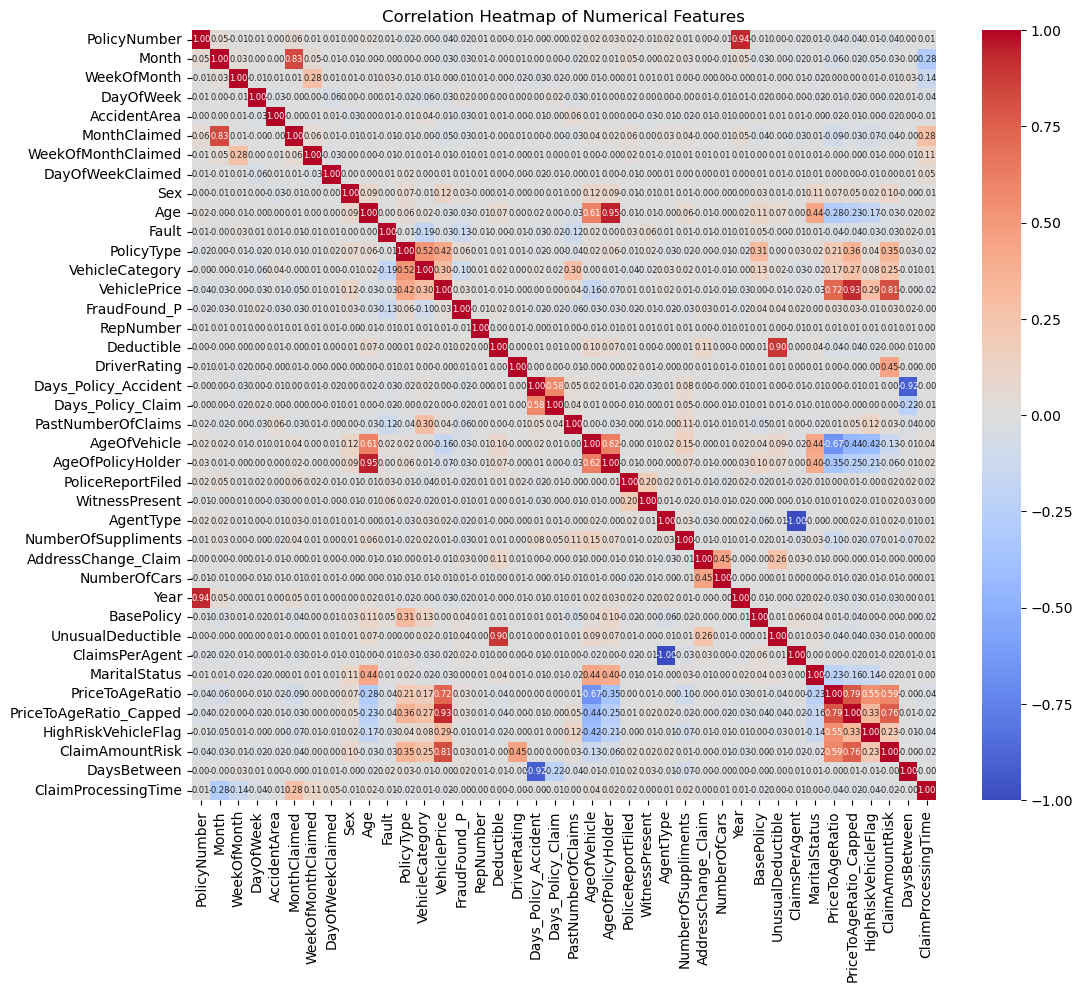

In [34]:
# Correlation heatmap
corr = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f",annot_kws={"size": 6})
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# **Issue: Curse of Dimensionality**

The "curse of dimensionality" refers to the challenges that arise when working with high-dimensional data such as increased computational complexity and difficulty in visualization and interpretation.

Since our features contain both categorical and numerical data, we have applied several techniques to make the data more compatible. For numerical data which are far apart, we will normalize the data to ensure that they have similar ranges. For categorical data, we use label encoding to encode the categorical data into numerical values.

Hence, by ploting a histogram we can determine if our data is currently facing issue by examining the shape and the standard deviation of the plot.


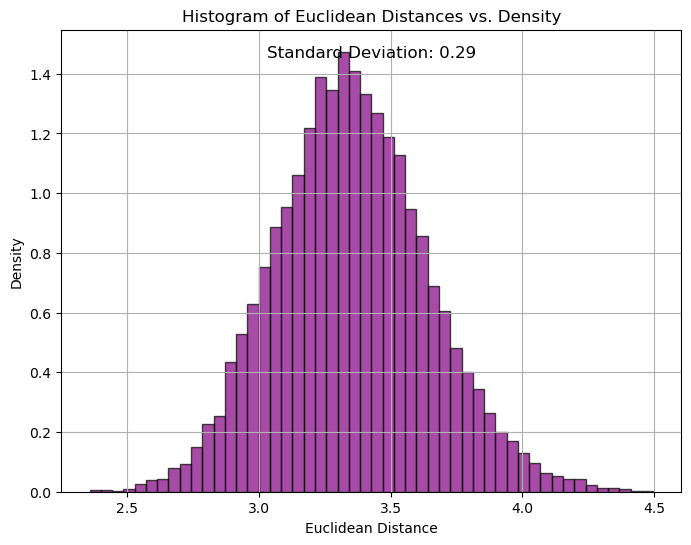

In [35]:
from sklearn.preprocessing import MinMaxScaler

# Drop the columns you don't need
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)

# Normalize the data (scaling between 0 and 1)
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Compute Euclidean distances between samples and origin
distances = np.linalg.norm(X_normalized, axis=1)

# Calculate standard deviation of Euclidean distances
std_dev = np.std(distances)

# Plot histogram with density
plt.figure(figsize=(8, 6))
plt.hist(distances, bins=50, density=True, edgecolor='black', alpha=0.7, color='purple')
plt.title('Histogram of Euclidean Distances vs. Density')
plt.xlabel('Euclidean Distance')
plt.ylabel('Density')
plt.grid(True)

# Add standard deviation to the plot
plt.text(0.5, 0.95, f'Standard Deviation: {std_dev:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

plt.show()


The plot suggests a normally distributed curve with a rounded peak and an acceptable level of standard deviation. Thus, it appears that the features excluding FraudFound_P does not exhibit the **'Curse of Dimensionality.'** Nonetheless, we intend to proceed with feature selection as we suspect the presence of some meaningless or redundant features in the dataset.

# **Identifying Significant Variables**

For our feature selection, we use **Random Forest**, **XGBoost**, **Logistic Regression** and **Ridge (L2) Regularization**

> Aim:

 1. `Improve Model performance by reducing the risk of overfitting`
 2. `Increase training speed by reducing computational costs`
 3. `Remove redundant features that are not meaningful to us`
 4. `Simplify our model to enhance model interpretibility`


 Note: We will be implementing 4 different types of models to extract the importance scores of each variable, and find out the mean rank score of each variable to select the top 10 most important feature


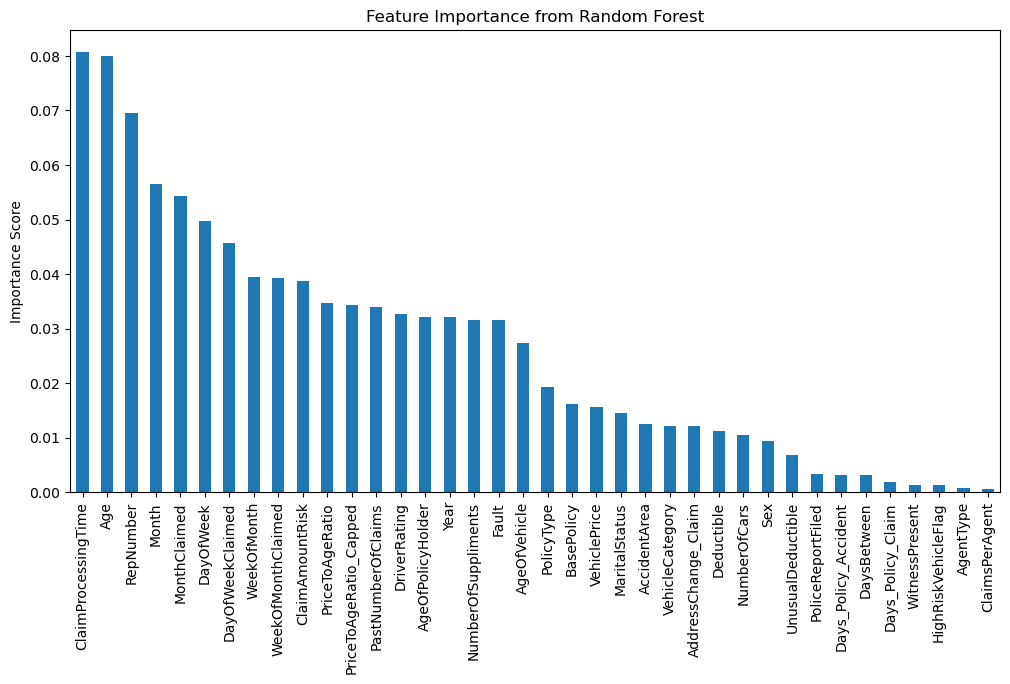

Top 5 Feature Importance Scores: 
ClaimProcessingTime    0.080693
Age                    0.080014
RepNumber              0.069540
Month                  0.056455
MonthClaimed           0.054293
dtype: float64


In [36]:
## Model 1: Random forest Classifier

from sklearn.ensemble import RandomForestClassifier

X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

rf = RandomForestClassifier(random_state=123)
rf.fit(X, y)
importance_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
importance_rf.plot(kind='bar')
plt.title("Feature Importance from Random Forest")
plt.ylabel("Importance Score")
plt.show()
print(f"Top 5 Feature Importance Scores: \n{importance_rf.head(5)}")

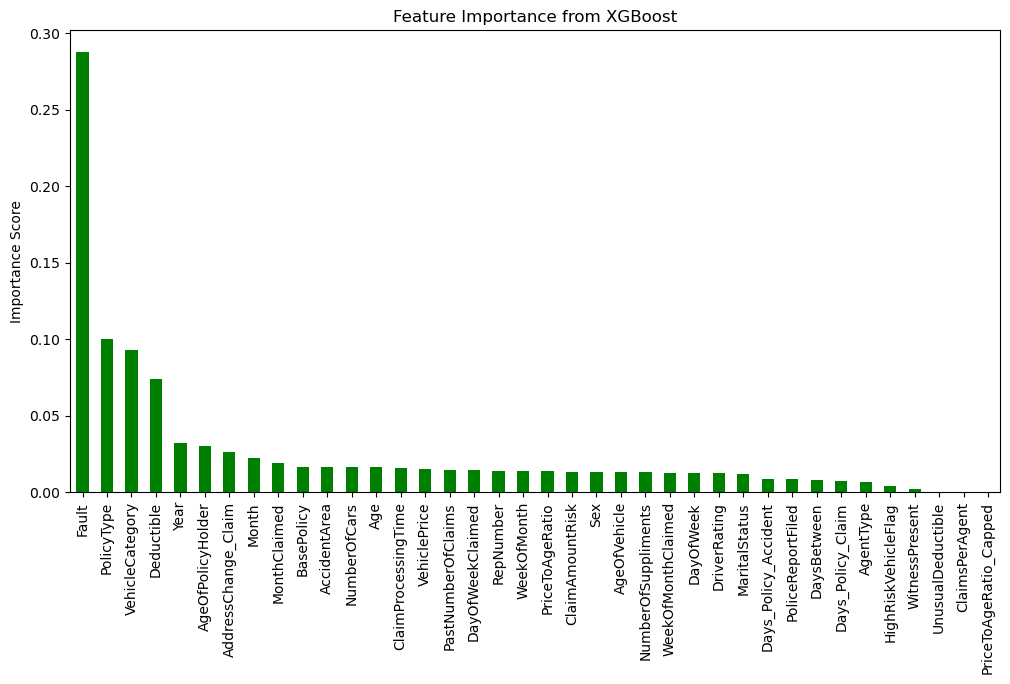

Top 5 Feature Importance Scores: 
Fault              0.287616
PolicyType         0.100248
VehicleCategory    0.093195
Deductible         0.074185
Year               0.031997
dtype: float32


In [37]:
## Model 2: XGBoost

import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the data
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

# Train the XGBoost model
model = xgb.XGBClassifier(random_state=123)
model.fit(X, y)

# Get feature importance
importance_xgb = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot the feature importance scores
plt.figure(figsize=(12, 6))
importance_xgb.plot(kind='bar', color='green')
plt.title("Feature Importance from XGBoost")
plt.ylabel("Importance Score")
plt.show()

print(f"Top 5 Feature Importance Scores: \n{importance_xgb.head(5)}")



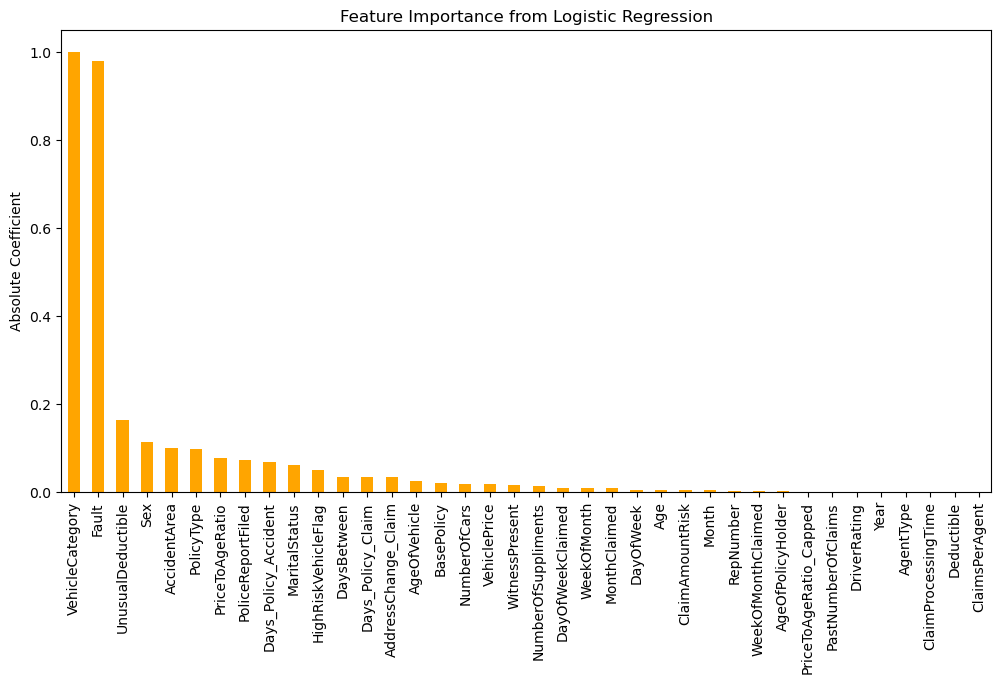

Top 5 Feature Importance Scores: 
VehicleCategory      1.000000
Fault                0.980458
UnusualDeductible    0.164192
Sex                  0.114073
AccidentArea         0.099650
dtype: float64


In [38]:
## Model 3: Logistic Regression

from sklearn.linear_model import LogisticRegression

X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

lr = LogisticRegression(random_state=123, max_iter=5000)
lr.fit(X, y)
# Use absolute coefficients because the sign is not as important as the magnitude.
# Use normalized coefficients for better comparison with other models
importance_lr = pd.Series((np.abs(lr.coef_[0]) / np.abs(lr.coef_[0]).max()), index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12,6))
importance_lr.plot(kind='bar', color='orange')
plt.title("Feature Importance from Logistic Regression")
plt.ylabel("Absolute Coefficient")
plt.show()

print(f"Top 5 Feature Importance Scores: \n{importance_lr.head(5)}")

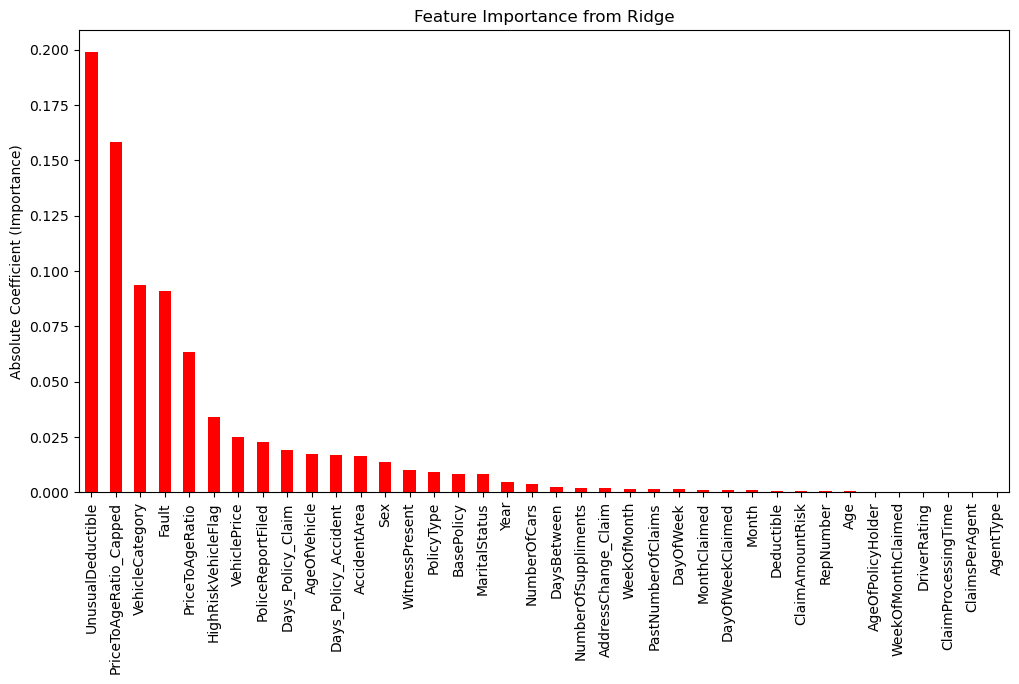

Top 5 Feature Importance Scores: 
UnusualDeductible         0.198820
PriceToAgeRatio_Capped    0.158358
VehicleCategory           0.093514
Fault                     0.090714
PriceToAgeRatio           0.063348
dtype: float64


In [39]:
## Model 4: Ridge Regression (L2 regularization)

from sklearn.linear_model import Ridge

X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

ridge = Ridge(random_state=123)
ridge.fit(X, y)

importance_l2 = pd.Series(np.abs(ridge.coef_), index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
importance_l2.plot(kind='bar', color='red')
plt.title("Feature Importance from Ridge")
plt.ylabel("Absolute Coefficient (Importance)")
plt.show()

print(f"Top 5 Feature Importance Scores: \n{importance_l2.head(5)}")

In [40]:
ranks_rf = importance_rf.rank(ascending=False)
ranks_xgb = importance_xgb.rank(ascending=False)
ranks_lr = importance_lr.rank(ascending=False)
ranks_l2 = importance_l2.rank(ascending=False)

# Combine the ranks into a single DataFrame
rank_df = pd.DataFrame({
    'RF': ranks_rf,
    'XGB': ranks_xgb,
    'LR': ranks_lr,
    'RIDGE': ranks_l2
})

# Compute the average rank across models
rank_df['Average_Rank'] = rank_df.mean(axis=1)

# Sort by average rank to get the overall top features
overall_ranking = rank_df.sort_values('Average_Rank')
print("Overall Top 10 Features Based on Average Rank:")
print(overall_ranking.head(10))

Overall Top 10 Features Based on Average Rank:
                   RF   XGB    LR  RIDGE  Average_Rank
Fault            18.0   1.0   2.0    4.0          6.25
VehicleCategory  25.0   3.0   1.0    3.0          8.00
PriceToAgeRatio  11.0  20.0   7.0    5.0         10.75
PolicyType       20.0   2.0   6.0   15.0         10.75
AccidentArea     24.0  11.0   5.0   12.0         13.00
VehiclePrice     22.0  15.0  18.0    7.0         15.50
BasePolicy       21.0  10.0  16.0   16.0         15.75
MonthClaimed      5.0   9.0  23.0   26.0         15.75
AgeOfVehicle     19.0  23.0  15.0   10.0         16.75
Month             4.0   8.0  27.0   28.0         16.75


In [41]:
#Full list of overall ranking
overall_ranking

,RF,XGB,LR,RIDGE,Average_Rank
Fault,18.0,1.0,2.0,4.0,6.25
VehicleCategory,25.0,3.0,1.0,3.0,8.00
PriceToAgeRatio,11.0,20.0,7.0,5.0,10.75
PolicyType,20.0,2.0,6.0,15.0,10.75
AccidentArea,24.0,11.0,5.0,12.0,13.00
VehiclePrice,22.0,15.0,18.0,7.0,15.50
BasePolicy,21.0,10.0,16.0,16.0,15.75
MonthClaimed,5.0,9.0,23.0,26.0,15.75
AgeOfVehicle,19.0,23.0,15.0,10.0,16.75
Month,4.0,8.0,27.0,28.0,16.75


Since Month and MonthClaimed are similar, we can remove it from the top 10 features and include the 11th ranked feature instead (AddressChange_Claim)

# **Feature Selection**

## Multi-Filter Feature Selection

In [42]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.cluster import AffinityPropagation

## Helper functions

def preprocess(S, target_col='FraudFound_P', test_size=0.3, random_state=123):
    X = S.drop(columns=[target_col])
    y = S[target_col]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def FeatureRankingrf(X, y): # Model 1: Random Forest
    """
    Rank features using feature_importances_ from Random Forest.
    Returns a list of feature names sorted from most important to least.
    """
    rf = RandomForestClassifier(random_state=123)
    rf.fit(X, y)
    importance = rf.feature_importances_
    features = X.columns.tolist()
    ranking = sorted(zip(features, importance), key=lambda x: x[1], reverse=True)
    return [f for f, imp in ranking]

def FeatureRankingxgb(X, y): # Model 2: XGBoost
    """
    Rank features using a XGBoost's coefficients.
    Returns a list of feature names sorted from most important to least.
    """
    xb = xgb.XGBClassifier(random_state=123)
    xb.fit(X, y)
    importance = xb.feature_importances_
    features = X.columns.tolist()
    ranking = sorted(zip(features, importance), key=lambda x: x[1], reverse=True)
    return [f for f, imp in ranking]
    
def FeatureRankinglr(X, y): # Model 3: Logistic Regression
    """
    Rank features using absolute coefficients from Logistic Regression.
    Returns a list of feature names sorted from most important to least.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lr = LogisticRegression(max_iter=10000, random_state=123)
    lr.fit(X_scaled, y)
    # Use absolute coefficients because the sign is not as important as the magnitude.
    # Use normalized coefficients for better comparison with other models
    importance = np.abs(lr.coef_[0]) / np.abs(lr.coef_[0]).max()
    features = X.columns.tolist()
    ranking = sorted(zip(features, importance), key=lambda x: x[1], reverse=True)
    return [f for f, imp in ranking]

def drop_lowest_features(X, ranking, e):
    """
    Given a ranking (a list of features sorted descending by importance) and a number e,
    drop the lowest e features from X and return the reduced X along with the list of dropped features.
    """
    features_to_drop = ranking[-e:]  # the last e features in the ranking
    return X.drop(columns=features_to_drop), features_to_drop

def Correlation(X, c):
    """
    Compute the absolute correlation matrix for X and threshold values below c to zero.
    """
    corr = X.corr().abs()
    # Set values below threshold c to 0 to emphasize stronger correlations
    corr_thresholded = corr.where(corr >= c, other=0)
    return corr_thresholded

def AffinityPropagationClustering(similarity_matrix, p):
    """
    Perform Affinity Propagation clustering using a precomputed similarity matrix.
    p is used as the preference parameter.
    Returns a dictionary mapping each cluster label to the list of features in that cluster.
    """
    ap = AffinityPropagation(affinity='precomputed', preference=p, max_iter=500, random_state=123)
    ap.fit(similarity_matrix)
    clusters = {}
    for label, feature in zip(ap.labels_, similarity_matrix.index):
        clusters.setdefault(label, []).append(feature)
    return clusters

def get_delegates(ranking, clusters):
    """
    For each cluster, select the delegate as the feature that appears highest in the ranking list.
    """
    delegates = []
    for cluster_features in clusters.values():
        # Choose the feature with the smallest index in the ranking (i.e., most important)
        best = min(cluster_features, key=lambda f: ranking.index(f) if f in ranking else float('inf'))
        delegates.append(best)
    return delegates


In [43]:
def MFFS(S, e, p, c, target_col='FraudFound_P'):
    """
    Multi-Filter Feature Selection (MFFS) algorithm.
    Inputs:
      - S: DataFrame of data including features and target variable.
      - e: Number of lowest-ranked features to drop per filter (e.g., 5% of total features)
      - p: Preference parameter for Affinity Propagation (e.g., the median of similarity values)
      - c: Correlation threshold for the similarity matrix
      - target_col: Name of the target variable column.
    Outputs:
      - S_prime: DataFrame with only the selected features.
      - SF: List of selected feature names.
    """
    # Step 1: Preprocess data (split into train/test)
    xtrain, xtest, ytrain, ytest = preprocess(S, target_col=target_col)
    
    # Step 2: Get feature rankings from three filter methods
    VIlr = FeatureRankinglr(xtrain, ytrain)
    VIxgb = FeatureRankingxgb(xtrain, ytrain)
    VIrf = FeatureRankingrf(xtrain, ytrain)
    
    SF = []  # Selected Features
    ranking_list = [VIlr, VIxgb, VIrf]
    
    # For each filter method's ranking:
    for ranking in ranking_list:
        # Step 3: Drop the lowest e features from xtrain (for the current ranking)
        xtrain_reduced, _ = drop_lowest_features(xtrain, ranking, e)
        # Step 4: Compute the correlation similarity matrix with threshold c
        sm = Correlation(xtrain_reduced, c)
        # Step 5: Cluster the features using Affinity Propagation with preference p
        clusters = AffinityPropagationClustering(sm, p)
        # Step 6: From the ranking vector VI, select one delegate per cluster
        delegates = get_delegates(ranking, clusters)
        # Add delegates to the selected feature set (SF) if not already included
        for feat in delegates:
            if feat not in SF:
                SF.append(feat)
    
    # Subset the original xtrain and xtest to only include the selected features
    xtrain_selected = xtrain[SF]
    xtest_selected = xtest[SF]
    # Optionally, concatenate train and test sets (or return them separately)
    S_prime = pd.concat([xtrain_selected, xtest_selected], axis=0)
    
    return S_prime, SF

In [44]:
numeric_df_copy = numeric_df.drop(columns = ['PolicyNumber'])

#Values of e, p and c have been trial and tested to get the optimal output with full convergence
S_prime, selected_features = MFFS(numeric_df_copy, e=18, p=0, c=0.5, target_col='FraudFound_P')
print("Selected features:", selected_features)

Selected features: ['DriverRating', 'AccidentArea', 'AgeOfVehicle', 'Fault', 'VehicleCategory', 'UnusualDeductible', 'WitnessPresent', 'MonthClaimed', 'Year', 'Sex', 'PolicyType', 'Deductible', 'ClaimProcessingTime', 'WeekOfMonth', 'RepNumber', 'Age', 'NumberOfSuppliments', 'ClaimAmountRisk']


In [45]:
S_prime

,DriverRating,AccidentArea,AgeOfVehicle,Fault,VehicleCategory,UnusualDeductible,WitnessPresent,MonthClaimed,Year,Sex,PolicyType,Deductible,ClaimProcessingTime,WeekOfMonth,RepNumber,Age,NumberOfSuppliments,ClaimAmountRisk
6794,3,1,6,0,1,0,0,1,1995,1,11,400,360,5,9,27,5,3
9946,1,1,6,0,1,0,0,4,1995,0,11,400,419,2,7,34,5,1
9765,1,1,6,0,1,1,0,5,1995,1,11,700,367,4,5,49,0,1
15174,1,1,6,0,2,0,0,11,1996,1,12,400,414,2,8,32,3,1
6676,4,1,7,0,2,0,0,10,1995,1,12,400,366,1,16,55,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10520,3,1,6,0,2,0,0,3,1995,1,21,400,360,1,12,41,5,15
2557,1,1,5,0,1,0,0,8,1994,1,11,400,374,4,6,34,3,1
381,4,1,4,1,2,0,0,2,1994,0,12,400,374,3,4,35,0,4
7899,3,1,6,1,2,0,0,4,1995,0,12,400,373,5,8,28,1,3


# **Visualisation**

We will first show the distribution of Fraud vs Non-Fraud cases, then present a dashboard of the selected features 

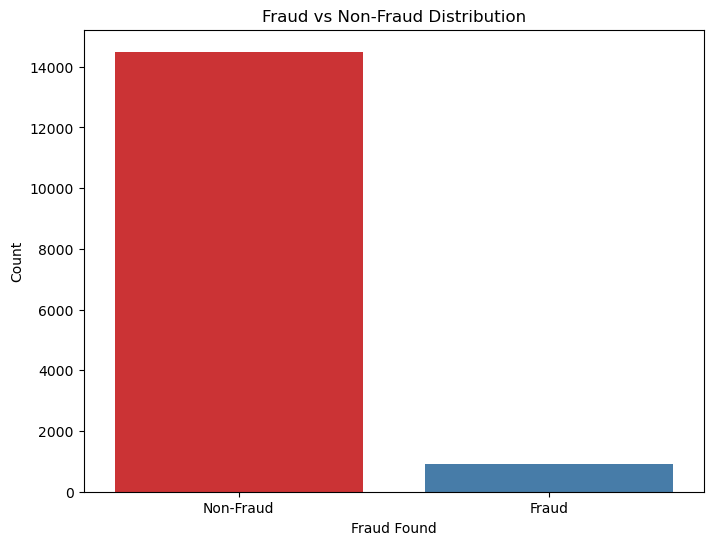

FraudFound_P
0    14496
1      923
Name: count, dtype: int64


In [46]:
fraud_vs_non_fraud = numeric_df['FraudFound_P'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8,6))
sns.countplot(x='FraudFound_P', data=numeric_df, palette='Set1')

# Customize the plot
plt.title('Fraud vs Non-Fraud Distribution')
plt.xlabel('Fraud Found')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])

# Show the plot
plt.show()
print(fraud_vs_non_fraud)

From above, we can see that the data is very imbalanced when it comes to fraud vs non-fraud

## Dashboard of top 10 features

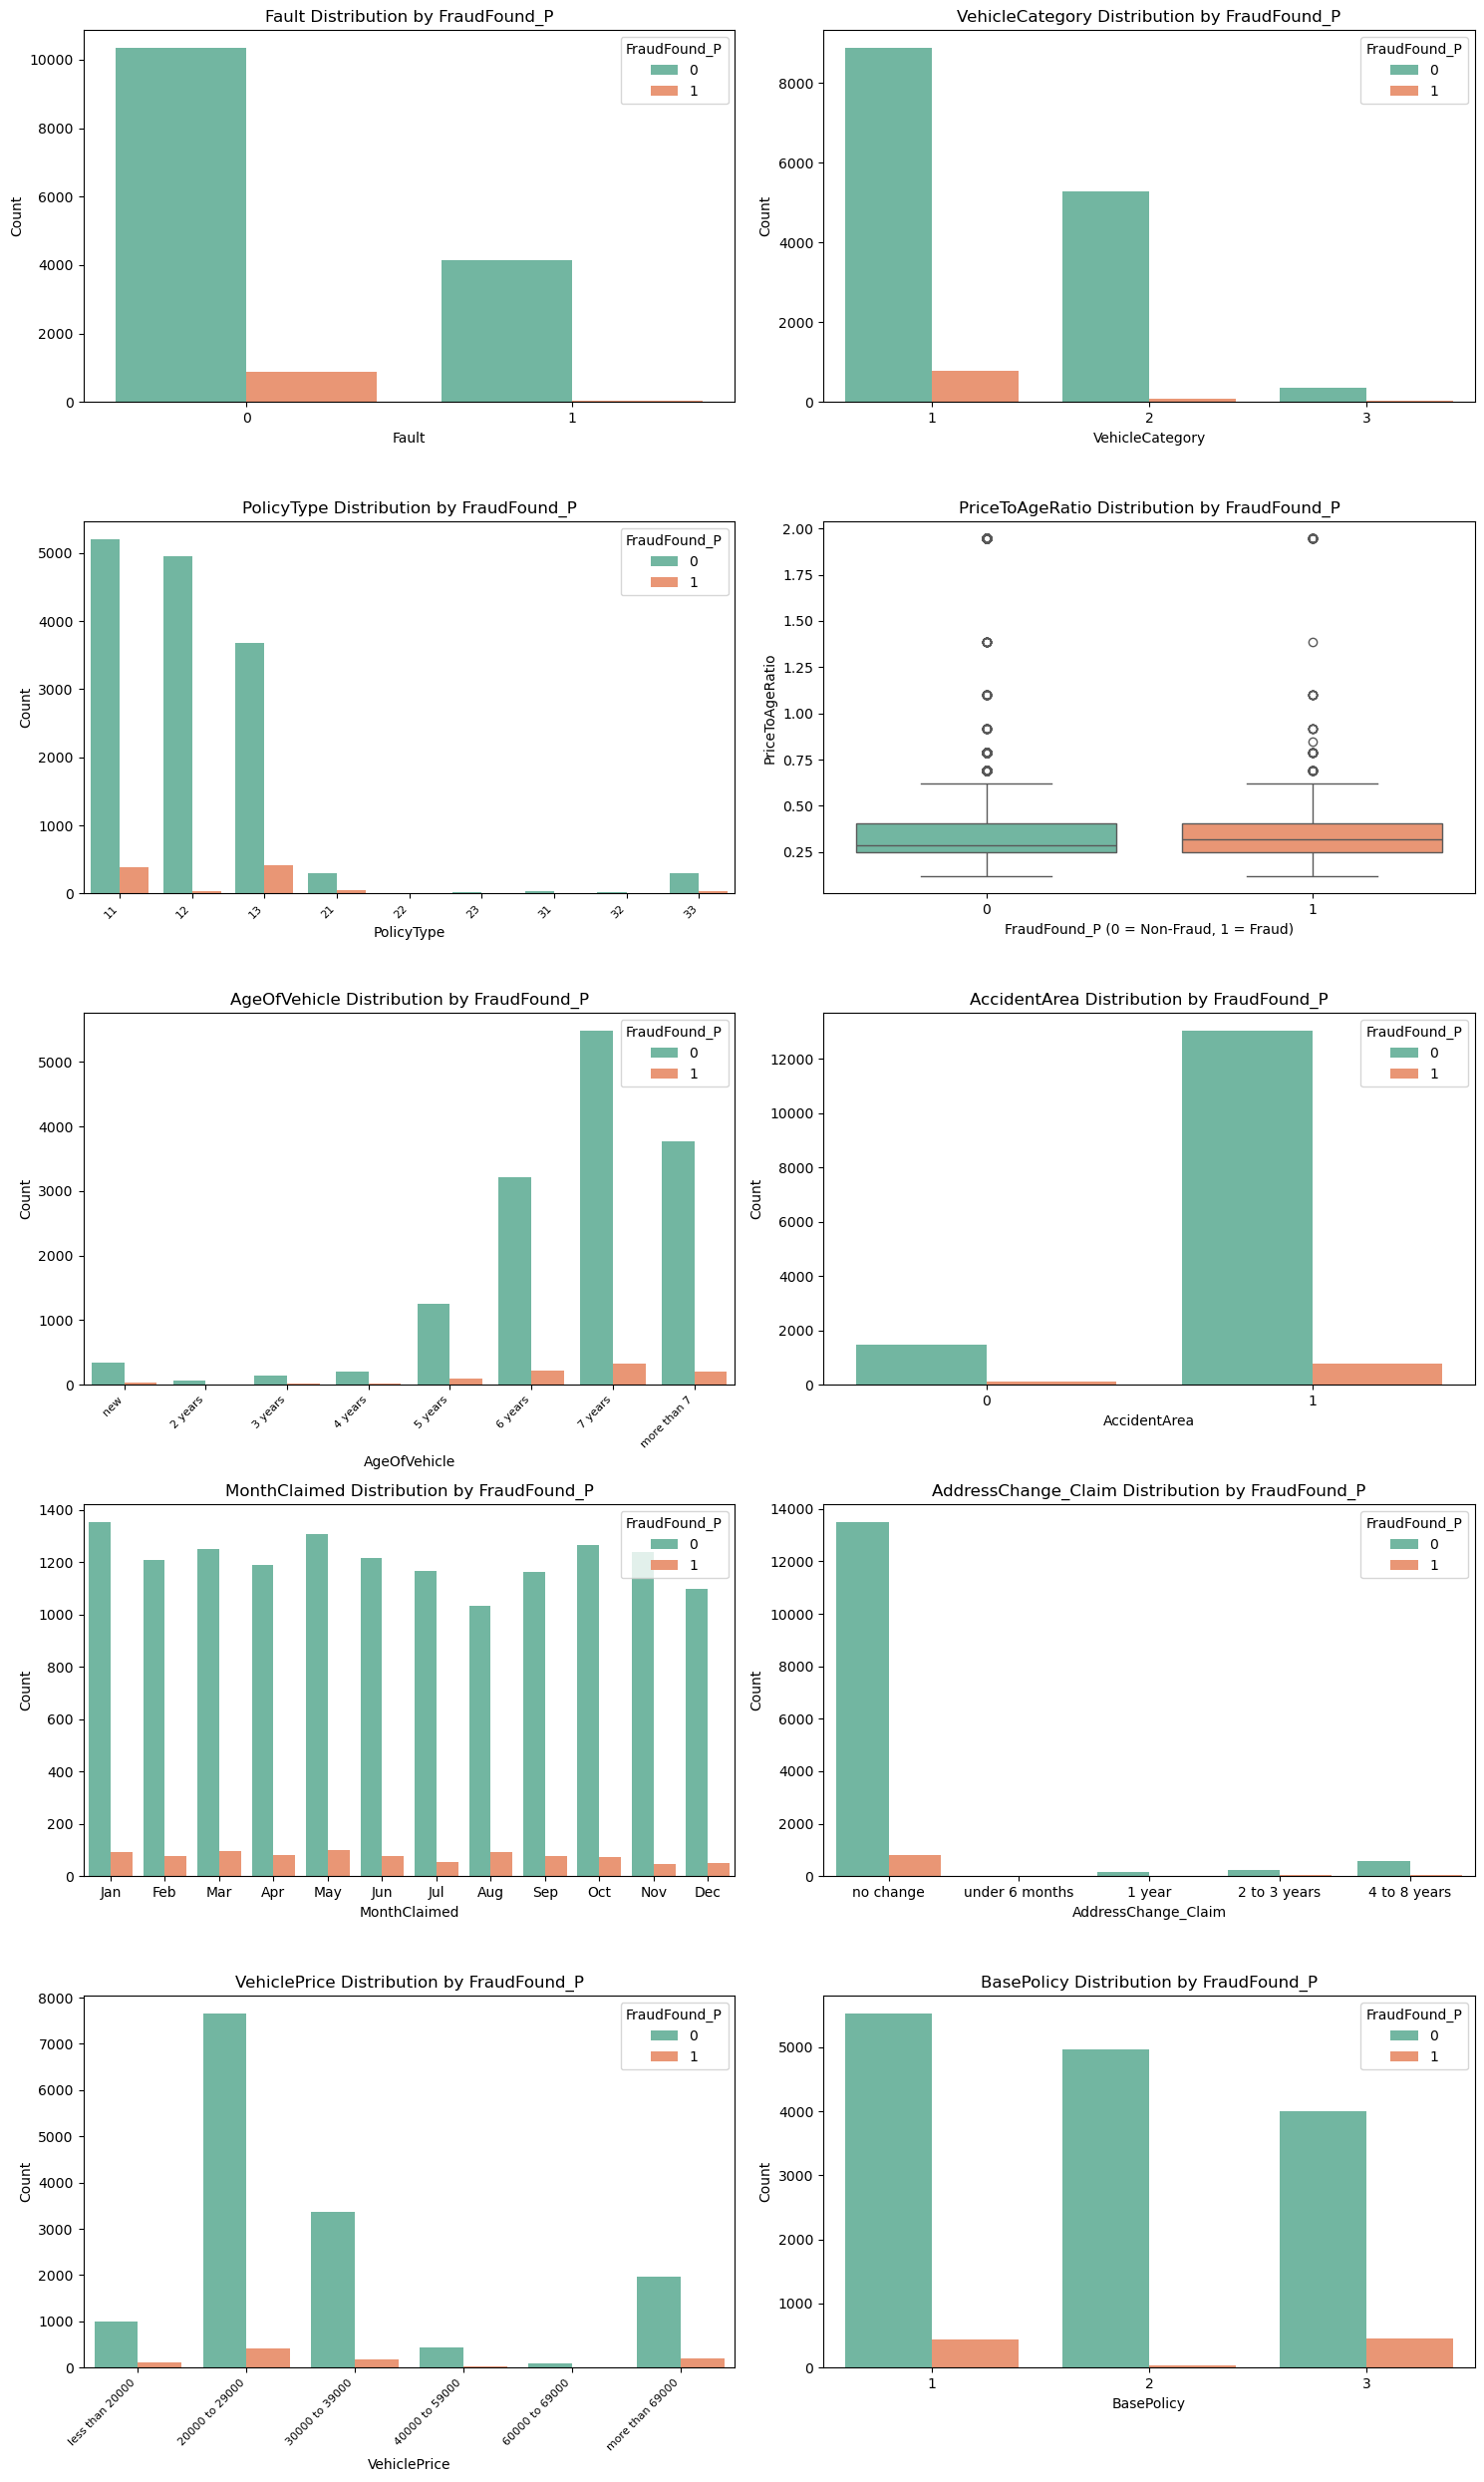

In [47]:
features = ['Fault', 'VehicleCategory', 'PolicyType', 'PriceToAgeRatio', 'AgeOfVehicle', 
            'AccidentArea', 'MonthClaimed', 'AddressChange_Claim', 'VehiclePrice', 'BasePolicy']

# Define mappings and orders for specific features
# sex_mapping = {0: 'Female', 1: 'Male'}
# sex_order = ['Female', 'Male']

month_claimed_mapping = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                         7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
month_claimed_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

vehicle_price_mapping = {0: 'less than 20000', 1: '20000 to 29000', 2: '30000 to 39000', 
                         3: '40000 to 59000', 4: '60000 to 69000', 5: 'more than 69000'}
vehicle_price_order = ['less than 20000', '20000 to 29000', '30000 to 39000', 
                       '40000 to 59000', '60000 to 69000', 'more than 69000']

address_change_mapping = {0: 'no change', 1: 'under 6 months', 2: '1 year', 
                          3: '2 to 3 years', 4: '4 to 8 years'}
address_change_order = ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years']

age_of_vehicle_mapping = {0: 'new', 1: '2 years', 2: '3 years', 3: '4 years', 4: '5 years', 
                         5: '6 years', 6: '7 years', 7: 'more than 7'}
age_of_vehicle_order = ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7']

# number_of_cars_mapping = {1: '1', 2: '2', 3: '3 to 4', 
#                           5: '5 to 8', 9: 'more than 8'}
# number_of_cars_order = ['1', '2', '3 to 4', '5 to 8', 'more than 8']

# Create a grid of subplots (5 rows x 2 columns)
fig, axs = plt.subplots(5, 2, figsize=(15, 25))
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    # Create a temporary dataframe for mapping without modifying the original
    temp_df = numeric_df.copy()
    order = None # default order remains None unless specified 
    
    # Apply mapping if the feature needs to be reverted to original labels
    if feature == 'Sex':
        temp_df[feature] = temp_df[feature].replace(sex_mapping)
        order = sex_order
    elif feature == 'MonthClaimed':
        temp_df[feature] = temp_df[feature].replace(month_claimed_mapping)
        order = month_claimed_order
    elif feature == 'VehiclePrice':
        temp_df[feature] = temp_df[feature].replace(vehicle_price_mapping)
        order = vehicle_price_order
    elif feature == 'AddressChange_Claim':
        temp_df[feature] = temp_df[feature].replace(address_change_mapping)
        order = address_change_order
    elif feature == 'AgeOfVehicle':
        temp_df[feature] = temp_df[feature].replace(age_of_vehicle_mapping)
        order = age_of_vehicle_order
    # elif feature == 'NumberOfCars':
    #     temp_df[feature] = temp_df[feature].replace(number_of_cars_mapping)
    #     order = number_of_cars_order
        
    
    # Create the countplot for categorical features and lineplot for continuous features
    if feature == 'PriceToAgeRatio':
        sns.boxplot(x='FraudFound_P', y=feature, data=temp_df, palette='Set2', ax = ax)
        ax.set_title('PriceToAgeRatio Distribution by FraudFound_P')
        ax.set_xlabel('FraudFound_P (0 = Non-Fraud, 1 = Fraud)')
        ax.set_ylabel('PriceToAgeRatio')
    else:
        sns.countplot(x=feature, hue='FraudFound_P', data=temp_df, palette='Set2', ax=ax, order=order)
        ax.set_title(f'{feature} Distribution by FraudFound_P')
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')
    
    # For PolicyType and VehiclePrice, rotate x-axis labels 45° anticlockwise and reduce font size
    if (feature == 'PolicyType' or feature == 'VehiclePrice' or feature == 'AgeOfVehicle'):
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        
plt.tight_layout()
plt.show()

# Sampling methods

### Oversampling
Use X_train_oversampled, y_train_oversampled when doing the models

In [48]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Prepare the data
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80-20 split

# Define SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data to oversample the minority class 
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print("Class distribution after oversampling:")
print(pd.Series(y_train_oversampled).value_counts().to_string())




Class distribution after oversampling:
FraudFound_P
1    11611
0    11611


In [49]:
df_smote = pd.concat([X_train_oversampled, y_train_oversampled], axis = 1)
df_smote.shape

(23222, 39)

In [50]:
X_smote = df_smote.drop(columns="FraudFound_P")
y_smote = df_smote["FraudFound_P"]
print(X_smote.shape, y_smote.shape)

(23222, 38) (23222,)


## Correlation Thresholding

### Remove features that are highly correlated with each other

In [51]:
corr_matrix = X_smote.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_reduced = X_smote.drop(columns=to_drop)

In [52]:
X_reduced.shape

(23222, 36)

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

## Correlation Thresholding

### Remove features that are highly correlated with each other

In [54]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_reduced = X.drop(columns=to_drop)

In [55]:
X_reduced.shape

(15419, 36)

### Running the recursive feature elimination cross validation using the catboost classifier

In [56]:
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    random_seed=42,
    verbose=0
)

In [57]:
rfecv = RFECV(
    estimator=catboost_model,
    step=1,
    cv=StratifiedKFold(n_splits=5), 
    scoring='roc_auc',
    n_jobs=1 
)

In [58]:
rfecv.fit(X_reduced, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=<catboost.core.CatBoostClassifier object at 0x14592ced0>,
      n_jobs=1, scoring='roc_auc')

In [59]:
optimal_num_features = rfecv.n_features_
print(f"Optimal number of features: {optimal_num_features}")

Optimal number of features: 18


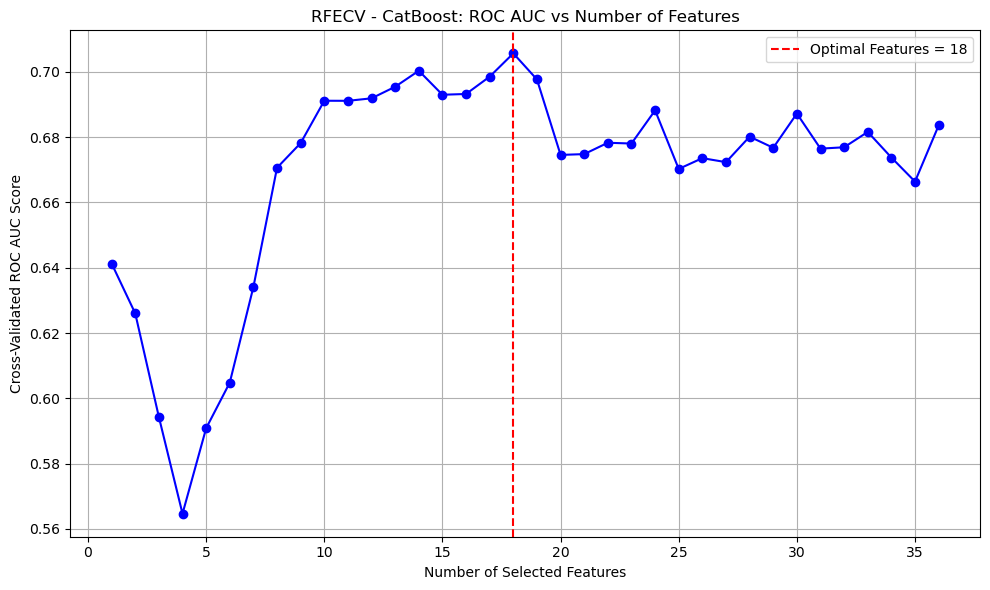

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    rfecv.cv_results_['mean_test_score'],
    marker='o',
    linestyle='-',
    color='blue'
)
plt.xlabel("Number of Selected Features")
plt.ylabel("Cross-Validated ROC AUC Score")
plt.title("RFECV - CatBoost: ROC AUC vs Number of Features")
plt.grid(True)
plt.axvline(x=rfecv.n_features_, color='red', linestyle='--', label=f'Optimal Features = {rfecv.n_features_}')
plt.legend()
plt.tight_layout()
plt.show()

In [61]:
X_selected = rfecv.transform(X_reduced)
selected_feature_indices = np.where(rfecv.support_)[0]
selected_feature_names = X_reduced.columns[selected_feature_indices]
X_rfecv = pd.DataFrame(X_selected, columns=selected_feature_names)

In [62]:
feature_ranking = pd.Series(rfecv.ranking_, index=X_reduced.columns)
feature_ranking = feature_ranking.sort_values()
feature_ranking.head(10)

Month                     1
PriceToAgeRatio_Capped    1
BasePolicy                1
Year                      1
AddressChange_Claim       1
NumberOfSuppliments       1
AgeOfVehicle              1
PastNumberOfClaims        1
DriverRating              1
Deductible                1
dtype: int64

## Multi-Filter Feature Selection

In [63]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.cluster import AffinityPropagation

## Helper functions

def preprocess(S, target_col='FraudFound_P', test_size=0.3, random_state=123):
    X = S.drop(columns=[target_col])
    y = S[target_col]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def FeatureRankingrf(X, y): # Model 1: Random Forest
    """
    Rank features using feature_importances_ from Random Forest.
    Returns a list of feature names sorted from most important to least.
    """
    rf = RandomForestClassifier(random_state=123)
    rf.fit(X, y)
    importance = rf.feature_importances_
    features = X.columns.tolist()
    ranking = sorted(zip(features, importance), key=lambda x: x[1], reverse=True)
    return [f for f, imp in ranking]

def FeatureRankingxgb(X, y): # Model 2: XGBoost
    """
    Rank features using a XGBoost's coefficients.
    Returns a list of feature names sorted from most important to least.
    """
    xb = xgb.XGBClassifier(random_state=123)
    xb.fit(X, y)
    importance = xb.feature_importances_
    features = X.columns.tolist()
    ranking = sorted(zip(features, importance), key=lambda x: x[1], reverse=True)
    return [f for f, imp in ranking]
    
def FeatureRankinglr(X, y): # Model 3: Logistic Regression
    """
    Rank features using absolute coefficients from Logistic Regression.
    Returns a list of feature names sorted from most important to least.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lr = LogisticRegression(max_iter=10000, random_state=123)
    lr.fit(X_scaled, y)
    # Use absolute coefficients because the sign is not as important as the magnitude.
    # Use normalized coefficients for better comparison with other models
    importance = np.abs(lr.coef_[0]) / np.abs(lr.coef_[0]).max()
    features = X.columns.tolist()
    ranking = sorted(zip(features, importance), key=lambda x: x[1], reverse=True)
    return [f for f, imp in ranking]

def drop_lowest_features(X, ranking, e):
    """
    Given a ranking (a list of features sorted descending by importance) and a number e,
    drop the lowest e features from X and return the reduced X along with the list of dropped features.
    """
    features_to_drop = ranking[-e:]  # the last e features in the ranking
    return X.drop(columns=features_to_drop), features_to_drop

def Correlation(X, c):
    """
    Compute the absolute correlation matrix for X and threshold values below c to zero.
    """
    corr = X.corr().abs()
    # Set values below threshold c to 0 to emphasize stronger correlations
    corr_thresholded = corr.where(corr >= c, other=0)
    return corr_thresholded

def AffinityPropagationClustering(similarity_matrix, p):
    """
    Perform Affinity Propagation clustering using a precomputed similarity matrix.
    p is used as the preference parameter.
    Returns a dictionary mapping each cluster label to the list of features in that cluster.
    """
    ap = AffinityPropagation(affinity='precomputed', preference=p, max_iter=500, random_state=123)
    ap.fit(similarity_matrix)
    clusters = {}
    for label, feature in zip(ap.labels_, similarity_matrix.index):
        clusters.setdefault(label, []).append(feature)
    return clusters

def get_delegates(ranking, clusters):
    """
    For each cluster, select the delegate as the feature that appears highest in the ranking list.
    """
    delegates = []
    for cluster_features in clusters.values():
        # Choose the feature with the smallest index in the ranking (i.e., most important)
        best = min(cluster_features, key=lambda f: ranking.index(f) if f in ranking else float('inf'))
        delegates.append(best)
    return delegates


In [64]:
def MFFS(S, e, p, c, target_col='FraudFound_P'):
    """
    Multi-Filter Feature Selection (MFFS) algorithm.
    Inputs:
      - S: DataFrame of data including features and target variable.
      - e: Number of lowest-ranked features to drop per filter (e.g., 5% of total features)
      - p: Preference parameter for Affinity Propagation (e.g., the median of similarity values)
      - c: Correlation threshold for the similarity matrix
      - target_col: Name of the target variable column.
    Outputs:
      - S_prime: DataFrame with only the selected features.
      - SF: List of selected feature names.
    """
    # Step 1: Preprocess data (split into train/test)
    xtrain, xtest, ytrain, ytest = preprocess(S, target_col=target_col)
    
    # Step 2: Get feature rankings from three filter methods
    VIlr = FeatureRankinglr(xtrain, ytrain)
    VIxgb = FeatureRankingxgb(xtrain, ytrain)
    VIrf = FeatureRankingrf(xtrain, ytrain)
    
    SF = []  # Selected Features
    ranking_list = [VIlr, VIxgb, VIrf]
    
    # For each filter method's ranking:
    for ranking in ranking_list:
        # Step 3: Drop the lowest e features from xtrain (for the current ranking)
        xtrain_reduced, _ = drop_lowest_features(xtrain, ranking, e)
        # Step 4: Compute the correlation similarity matrix with threshold c
        sm = Correlation(xtrain_reduced, c)
        # Step 5: Cluster the features using Affinity Propagation with preference p
        clusters = AffinityPropagationClustering(sm, p)
        # Step 6: From the ranking vector VI, select one delegate per cluster
        delegates = get_delegates(ranking, clusters)
        # Add delegates to the selected feature set (SF) if not already included
        for feat in delegates:
            if feat not in SF:
                SF.append(feat)
    
    # Subset the original xtrain and xtest to only include the selected features
    xtrain_selected = xtrain[SF]
    xtest_selected = xtest[SF]
    # Optionally, concatenate train and test sets (or return them separately)
    S_prime = pd.concat([xtrain_selected, xtest_selected], axis=0)
    
    return S_prime, SF

In [65]:
numeric_df_copy = numeric_df.drop(columns = ['PolicyNumber'])

#Values of e, p and c have been trial and tested to get the optimal output with full convergence
S_prime, selected_features = MFFS(numeric_df_copy, e=18, p=0, c=0.5, target_col='FraudFound_P')
print("Selected features:", selected_features)

Selected features: ['DriverRating', 'AccidentArea', 'AgeOfVehicle', 'Fault', 'VehicleCategory', 'UnusualDeductible', 'WitnessPresent', 'MonthClaimed', 'Year', 'Sex', 'PolicyType', 'Deductible', 'ClaimProcessingTime', 'WeekOfMonth', 'RepNumber', 'Age', 'NumberOfSuppliments', 'ClaimAmountRisk']


In [66]:
S_prime

,DriverRating,AccidentArea,AgeOfVehicle,Fault,VehicleCategory,UnusualDeductible,WitnessPresent,MonthClaimed,Year,Sex,PolicyType,Deductible,ClaimProcessingTime,WeekOfMonth,RepNumber,Age,NumberOfSuppliments,ClaimAmountRisk
6794,3,1,6,0,1,0,0,1,1995,1,11,400,360,5,9,27,5,3
9946,1,1,6,0,1,0,0,4,1995,0,11,400,419,2,7,34,5,1
9765,1,1,6,0,1,1,0,5,1995,1,11,700,367,4,5,49,0,1
15174,1,1,6,0,2,0,0,11,1996,1,12,400,414,2,8,32,3,1
6676,4,1,7,0,2,0,0,10,1995,1,12,400,366,1,16,55,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10520,3,1,6,0,2,0,0,3,1995,1,21,400,360,1,12,41,5,15
2557,1,1,5,0,1,0,0,8,1994,1,11,400,374,4,6,34,3,1
381,4,1,4,1,2,0,0,2,1994,0,12,400,374,3,4,35,0,4
7899,3,1,6,1,2,0,0,4,1995,0,12,400,373,5,8,28,1,3


# **Visualisation**

We will first show the distribution of Fraud vs Non-Fraud cases, then present a dashboard of the selected features 

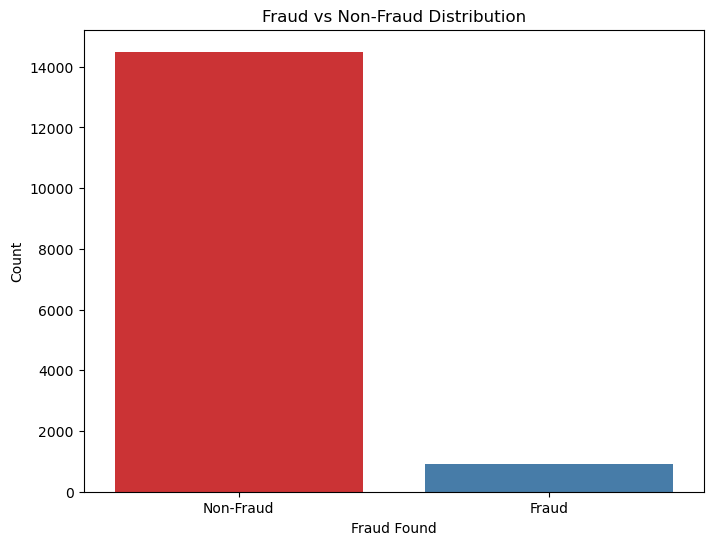

FraudFound_P
0    14496
1      923
Name: count, dtype: int64


In [67]:
fraud_vs_non_fraud = numeric_df['FraudFound_P'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8,6))
sns.countplot(x='FraudFound_P', data=numeric_df, palette='Set1')

# Customize the plot
plt.title('Fraud vs Non-Fraud Distribution')
plt.xlabel('Fraud Found')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])

# Show the plot
plt.show()
print(fraud_vs_non_fraud)

From above, we can see that the data is very imbalanced when it comes to fraud vs non-fraud

## Dashboard of top 10 features

In [68]:
df['Age'] = numeric_df['Age']

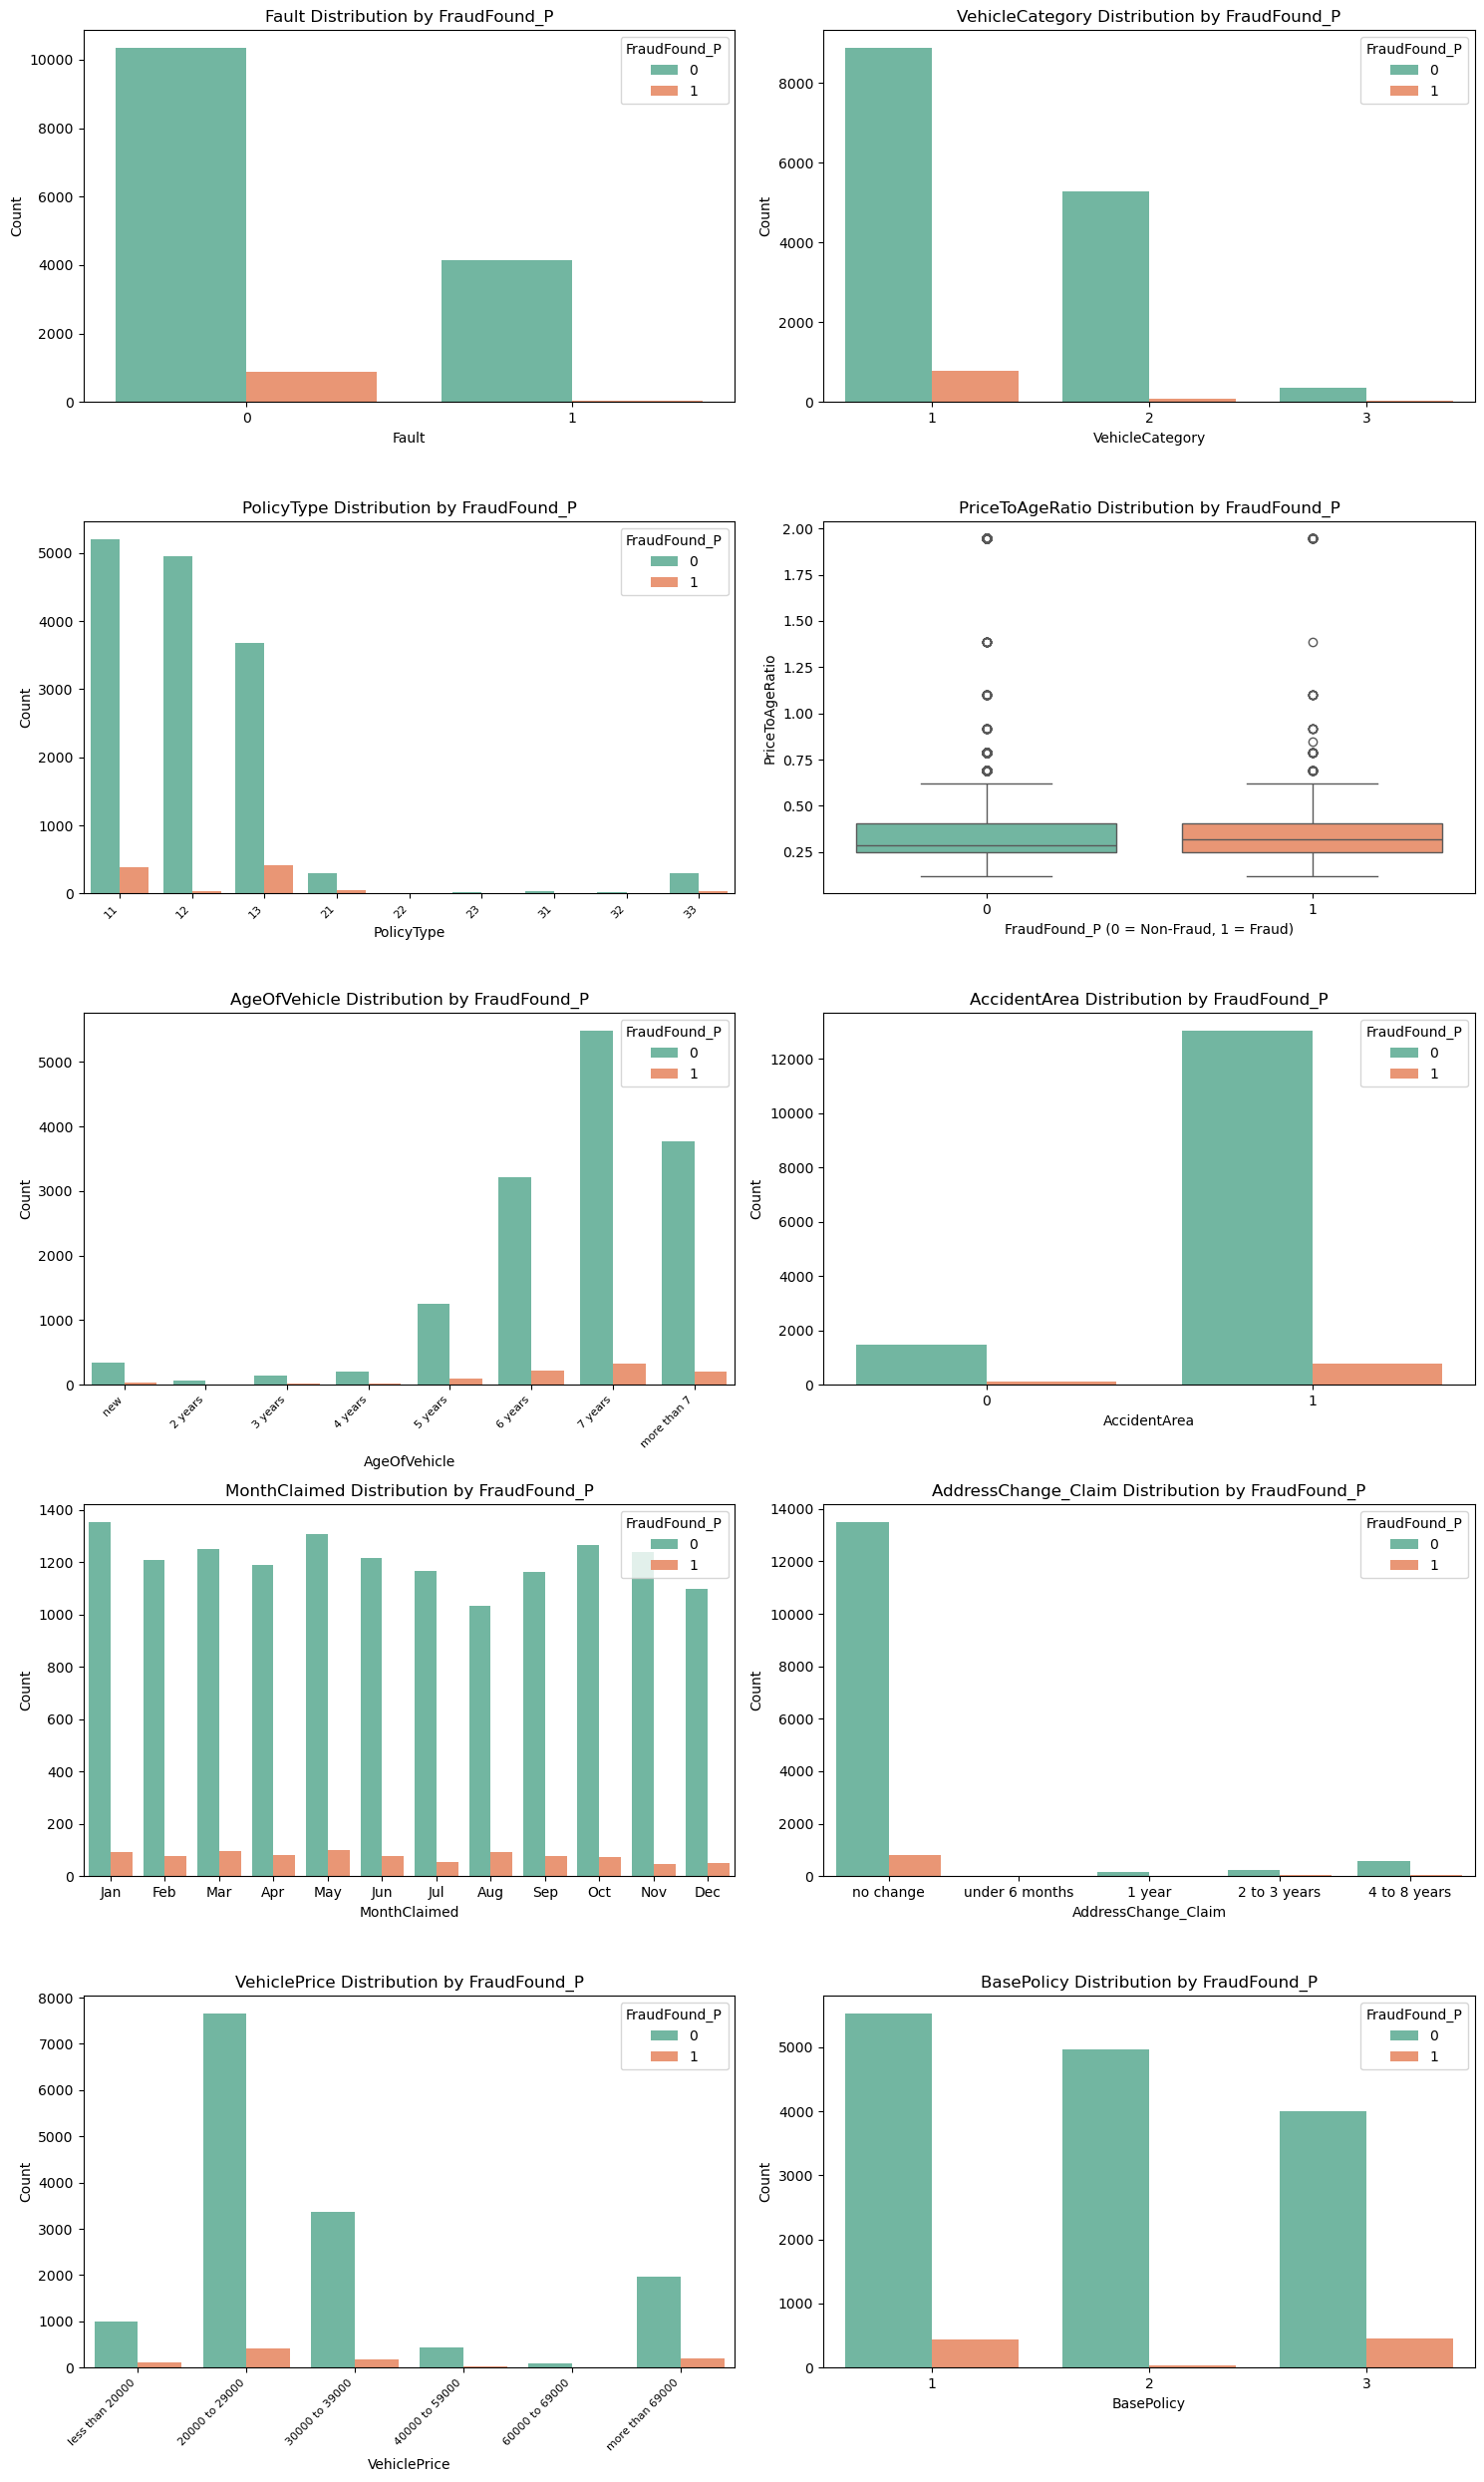

In [69]:
features = ['Fault', 'VehicleCategory', 'PolicyType', 'PriceToAgeRatio', 'AgeOfVehicle', 
            'AccidentArea', 'MonthClaimed', 'AddressChange_Claim', 'VehiclePrice', 'BasePolicy']

# Define mappings and orders for specific features
# sex_mapping = {0: 'Female', 1: 'Male'}
# sex_order = ['Female', 'Male']

month_claimed_mapping = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                         7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
month_claimed_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

vehicle_price_mapping = {0: 'less than 20000', 1: '20000 to 29000', 2: '30000 to 39000', 
                         3: '40000 to 59000', 4: '60000 to 69000', 5: 'more than 69000'}
vehicle_price_order = ['less than 20000', '20000 to 29000', '30000 to 39000', 
                       '40000 to 59000', '60000 to 69000', 'more than 69000']

address_change_mapping = {0: 'no change', 1: 'under 6 months', 2: '1 year', 
                          3: '2 to 3 years', 4: '4 to 8 years'}
address_change_order = ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years']

age_of_vehicle_mapping = {0: 'new', 1: '2 years', 2: '3 years', 3: '4 years', 4: '5 years', 
                         5: '6 years', 6: '7 years', 7: 'more than 7'}
age_of_vehicle_order = ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7']

# number_of_cars_mapping = {1: '1', 2: '2', 3: '3 to 4', 
#                           5: '5 to 8', 9: 'more than 8'}
# number_of_cars_order = ['1', '2', '3 to 4', '5 to 8', 'more than 8']

# Create a grid of subplots (5 rows x 2 columns)
fig, axs = plt.subplots(5, 2, figsize=(15, 25))
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    # Create a temporary dataframe for mapping without modifying the original
    temp_df = numeric_df.copy()
    order = None # default order remains None unless specified 
    
    # Apply mapping if the feature needs to be reverted to original labels
    if feature == 'Sex':
        temp_df[feature] = temp_df[feature].replace(sex_mapping)
        order = sex_order
    elif feature == 'MonthClaimed':
        temp_df[feature] = temp_df[feature].replace(month_claimed_mapping)
        order = month_claimed_order
    elif feature == 'VehiclePrice':
        temp_df[feature] = temp_df[feature].replace(vehicle_price_mapping)
        order = vehicle_price_order
    elif feature == 'AddressChange_Claim':
        temp_df[feature] = temp_df[feature].replace(address_change_mapping)
        order = address_change_order
    elif feature == 'AgeOfVehicle':
        temp_df[feature] = temp_df[feature].replace(age_of_vehicle_mapping)
        order = age_of_vehicle_order
    # elif feature == 'NumberOfCars':
    #     temp_df[feature] = temp_df[feature].replace(number_of_cars_mapping)
    #     order = number_of_cars_order
        
    
    # Create the countplot for categorical features and lineplot for continuous features
    if feature == 'PriceToAgeRatio':
        sns.boxplot(x='FraudFound_P', y=feature, data=temp_df, palette='Set2', ax = ax)
        ax.set_title('PriceToAgeRatio Distribution by FraudFound_P')
        ax.set_xlabel('FraudFound_P (0 = Non-Fraud, 1 = Fraud)')
        ax.set_ylabel('PriceToAgeRatio')
    else:
        sns.countplot(x=feature, hue='FraudFound_P', data=temp_df, palette='Set2', ax=ax, order=order)
        ax.set_title(f'{feature} Distribution by FraudFound_P')
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')
    
    # For PolicyType and VehiclePrice, rotate x-axis labels 45° anticlockwise and reduce font size
    if (feature == 'PolicyType' or feature == 'VehiclePrice' or feature == 'AgeOfVehicle'):
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        
plt.tight_layout()
plt.show()

# Sampling methods

### Oversampling
Use X_train_oversampled, y_train_oversampled when doing the models

In [70]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Prepare the data
# X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
# y = numeric_df['FraudFound_P']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_rfecv, y, test_size=0.2, random_state=42)  # 80-20 split

# Define SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data to oversample the minority class 
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print("Class distribution after oversampling:")
print(pd.Series(y_train_oversampled).value_counts().to_string())




Class distribution after oversampling:
FraudFound_P
1    11611
0    11611


In [71]:
df_smote = pd.concat([X_train_oversampled, y_train_oversampled], axis = 1)
df_smote.shape

(23222, 19)

In [72]:
df_smote.to_csv("oversampled_df.csv",encoding = 'utf-8')

In [73]:
X_smote = df_smote.drop(columns="FraudFound_P")
y_smote = df_smote["FraudFound_P"]
print(X_smote.shape, y_smote.shape)

(23222, 18) (23222,)


In [74]:
print(pd.Series(y_test).value_counts().to_string())

FraudFound_P
0    2885
1     199


## Catboostclassifier without tuning

In [75]:
# Train catboost classifier model
cat_model = CatBoostClassifier(random_state=42)
cat_model.fit(X_train_oversampled, y_train_oversampled)

# Predictions
y_pred_cat = cat_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_cat)
conf_matrix = confusion_matrix(y_test, y_pred_cat)
classification_rep = classification_report(y_test, y_pred_cat)
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_cat))

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)


Learning rate set to 0.039461
0:	learn: 0.6406830	total: 5.15ms	remaining: 5.14s
1:	learn: 0.5939119	total: 11.6ms	remaining: 5.8s
2:	learn: 0.5598758	total: 18.2ms	remaining: 6.06s
3:	learn: 0.5315917	total: 22.2ms	remaining: 5.53s
4:	learn: 0.5026577	total: 26.6ms	remaining: 5.28s
5:	learn: 0.4801469	total: 30.5ms	remaining: 5.05s
6:	learn: 0.4533530	total: 34.2ms	remaining: 4.85s
7:	learn: 0.4289376	total: 37.9ms	remaining: 4.69s
8:	learn: 0.4071717	total: 42ms	remaining: 4.62s
9:	learn: 0.3872417	total: 47.9ms	remaining: 4.74s
10:	learn: 0.3707466	total: 51.8ms	remaining: 4.66s
11:	learn: 0.3552691	total: 55.5ms	remaining: 4.57s
12:	learn: 0.3402618	total: 59.5ms	remaining: 4.51s
13:	learn: 0.3219848	total: 63.6ms	remaining: 4.48s
14:	learn: 0.3127265	total: 69.3ms	remaining: 4.55s
15:	learn: 0.2983857	total: 73.6ms	remaining: 4.53s
16:	learn: 0.2920955	total: 77.8ms	remaining: 4.5s
17:	learn: 0.2842897	total: 81.9ms	remaining: 4.46s
18:	learn: 0.2701429	total: 85.9ms	remaining: 4.

## Hyperparameter tuning of catboostclassifier

In [76]:
# catboost algo
cat = CatBoostClassifier(
    verbose=0,
    random_state=42
)

# Define parameter grid
param_dict_cat = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 1, 2],
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV
search_cat = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_dict_cat,
    n_iter=20,  # try more for better results
    scoring='roc_auc',
    n_jobs=1,
    cv=cv,
    verbose=2,
    random_state=42
)

# Fit the search
search_cat.fit(X_train_oversampled, y_train_oversampled)

# Best params and score
print("Best Parameters:", search_cat.best_params_)
print("Best ROC AUC:", search_cat.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bagging_temperature=0, border_count=32, depth=10, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END bagging_temperature=0, border_count=32, depth=10, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END bagging_temperature=0, border_count=32, depth=10, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END bagging_temperature=0, border_count=128, depth=8, iterations=300, l2_leaf_reg=9, learning_rate=0.1; total time=   1.4s
[CV] END bagging_temperature=0, border_count=128, depth=8, iterations=300, l2_leaf_reg=9, learning_rate=0.1; total time=   1.4s
[CV] END bagging_temperature=0, border_count=128, depth=8, iterations=300, l2_leaf_reg=9, learning_rate=0.1; total time=   1.5s
[CV] END bagging_temperature=2, border_count=128, depth=8, iterations=500, l2_leaf_reg=9, learning_rate=0.01; total time=   2.3s
[CV] END bagging_temperature=2, border_

In [77]:
best_model_cat = search_cat.best_estimator_
y_pred_proba = best_model_cat.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.072).astype(int)

# Metrics
from sklearn.metrics import classification_report, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_proba))

[[2205  680]
 [  40  159]]
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      2885
           1       0.19      0.80      0.31       199

    accuracy                           0.77      3084
   macro avg       0.59      0.78      0.58      3084
weighted avg       0.93      0.77      0.82      3084

0.18951132300357568
0.7989949748743719
0.3063583815028902
ROC AUC on validation: 0.8596866481454064


## Logistic Regression without tuning

In [78]:
# Train logistic regression model
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train_oversampled, y_train_oversampled)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)
classification_rep = classification_report(y_test, y_pred_lr)
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_lr))

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)


ROC AUC on validation: 0.6248155857275981
Accuracy: 0.6219
Confusion Matrix:
[[1793 1092]
 [  74  125]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.62      0.75      2885
           1       0.10      0.63      0.18       199

    accuracy                           0.62      3084
   macro avg       0.53      0.62      0.47      3084
weighted avg       0.91      0.62      0.72      3084



## Hyperparameter tuning of Logistic Regression Model

In [79]:
# logistic regression algo
lr_model = LogisticRegression(verbose=0,random_state=42)

# Define parameter grid
param_dict_lr = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000],
}


# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV
search_lr = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=param_dict_lr,
    n_iter=20,  # try more for better results
    scoring='roc_auc',
    n_jobs=1,
    cv=cv,
    verbose=2,
    random_state=42
)

# Fit the search
search_lr.fit(X_train_oversampled, y_train_oversampled)

# Best params and score
print("Best Parameters:", search_lr.best_params_)
print("Best ROC AUC:", search_lr.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ......C=100, max_iter=1000, penalty=l2, solver=saga; total time=   1.9s
[CV] END ......C=100, max_iter=1000, penalty=l2, solver=saga; total time=   1.8s
[CV] END ......C=100, max_iter=1000, penalty=l2, solver=saga; total time=   1.8s
[CV] END C=1, max_iter=1000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=1, max_iter=1000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=1, max_iter=1000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ..C=100, max_iter=500, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=100, max_iter=500, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=100, max_iter=500, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ........C=10, max_iter=500, penalty=l2, solver=saga; total time=   1.0s
[CV] END ........C=10, max_iter=500, penalty=l2, solver=saga; total time=   1.0s
[CV] END ........C=10, max_iter=500, penalty=l2,

/Users/Student/anaconda3/envs/cleanenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
21 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Student/anaconda3/envs/cleanenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Student/anaconda3/envs/cleanenv/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/Student/anaconda3/envs/cleane

In [80]:
best_model_lr = search_lr.best_estimator_
y_pred_proba = best_model_lr.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.35).astype(int)

# Metrics
from sklearn.metrics import classification_report, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_proba))


[[1656 1229]
 [   9  190]]
              precision    recall  f1-score   support

           0       0.99      0.57      0.73      2885
           1       0.13      0.95      0.23       199

    accuracy                           0.60      3084
   macro avg       0.56      0.76      0.48      3084
weighted avg       0.94      0.60      0.70      3084

ROC AUC on validation: 0.7932365466848975


## RandomForestClassifier Model without tuning

In [81]:
rf_model = RandomForestClassifier(class_weight="balanced", random_state=36)
rf_model.fit(X_train_oversampled, y_train_oversampled)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("==== Random Forest ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_rf))

==== Random Forest ====
Accuracy: 0.9358
Confusion Matrix:
[[2876    9]
 [ 189   10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2885
           1       0.53      0.05      0.09       199

    accuracy                           0.94      3084
   macro avg       0.73      0.52      0.53      3084
weighted avg       0.91      0.94      0.91      3084

ROC AUC on validation: 0.5235658361129738


## Hyperparameter tuning of RandomForestClassifier model

In [82]:
# Random forest algo
rf_model = RandomForestClassifier(class_weight="balanced", verbose = 0,random_state=42)

# Define parameter grid
param_dict_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 5, 10],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
    'bootstrap': [True, False],  
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV
search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dict_rf,
    n_iter=20,  # try more for better results
    scoring='roc_auc',
    n_jobs=1,
    cv=cv,
    verbose=2,
    random_state=42
)

# Fit the search
search_rf.fit(X_train_oversampled, y_train_oversampled)

# Best params and score
print("Best Parameters:", search_rf.best_params_)
print("Best ROC AUC:", search_rf.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   5.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   5.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   5.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.4s


In [83]:
best_model_rf = search_rf.best_estimator_
y_pred_proba = best_model_rf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.15).astype(int)

# Metrics
from sklearn.metrics import classification_report, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_proba))

[[2414  471]
 [  81  118]]
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      2885
           1       0.20      0.59      0.30       199

    accuracy                           0.82      3084
   macro avg       0.58      0.71      0.60      3084
weighted avg       0.92      0.82      0.86      3084

ROC AUC on validation: 0.8285552546092682


## XGBoost without tuning

In [84]:
xgb_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_oversampled, y_train_oversampled)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("==== XGBoost ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_xgb))

==== XGBoost ====
Accuracy: 0.9306
Confusion Matrix:
[[2853   32]
 [ 182   17]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2885
           1       0.35      0.09      0.14       199

    accuracy                           0.93      3084
   macro avg       0.64      0.54      0.55      3084
weighted avg       0.90      0.93      0.91      3084

ROC AUC on validation: 0.5371676406294906


## Hyperparameter tuning of XGBoostClassifier

In [85]:
# Xgboost algo
xgb_model = xgb.XGBClassifier(eval_metric="logloss", random_state=42)

# Define parameter grid
param_dict_xgb = {
    'n_estimators': [100, 200],  # Number of boosting rounds
    'max_depth': [3, 5, 10, 15],  # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2],  # Step size at each iteration
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for training each tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used for each tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization 
    'reg_lambda': [0, 0.01, 0.1],  # L2 regularization
    'scale_pos_weight': [1, 5, 10],  # Controls balance of positive and negative weights
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV
search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dict_xgb,
    n_iter=20,  # try more for better results
    scoring='roc_auc',
    n_jobs=1,
    cv=cv,
    verbose=2,
    random_state=42
)

# Fit the search
search_xgb.fit(X_train_oversampled, y_train_oversampled)

# Best params and score
print("Best Parameters:", search_xgb.best_params_)
print("Best ROC AUC:", search_xgb.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_de

In [86]:
best_model_xgb = search_xgb.best_estimator_
y_pred_proba = best_model_xgb.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.025).astype(int)

# Metrics
from sklearn.metrics import classification_report, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_proba))

[[2193  692]
 [  39  160]]
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      2885
           1       0.19      0.80      0.30       199

    accuracy                           0.76      3084
   macro avg       0.59      0.78      0.58      3084
weighted avg       0.93      0.76      0.82      3084

ROC AUC on validation: 0.8548984088553687


## LightGBM without tuning

In [87]:
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train_oversampled, y_train_oversampled)
y_pred_lgb = lgb_model.predict(X_test)

# Evaluation
print("==== LightGBM ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_lgb))

==== LightGBM ====
Accuracy: 0.9371
Confusion Matrix:
[[2880    5]
 [ 189   10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2885
           1       0.67      0.05      0.09       199

    accuracy                           0.94      3084
   macro avg       0.80      0.52      0.53      3084
weighted avg       0.92      0.94      0.91      3084

ROC AUC on validation: 0.5242590770141871


## Hyperparameter tuning of LightGBM Model

In [88]:
# Lightgbm algo
lgb_model = lgb.LGBMClassifier(random_state=42, verbose = 0)

# Define parameter grid
param_dict_lgb = {
    'n_estimators': [100, 200],  # Number of boosting rounds
    'max_depth': [3, 5, 10, 15],  # Maximum depth of trees
    'learning_rate': [0.01, 0.1],  # Step size at each iteration
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for training each tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used for each tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization 
    'reg_lambda': [0, 0.01, 0.1],  # L2 regularization
    'scale_pos_weight': [1, 5, 10],  # Controls balance of positive and negative weights
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV
search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dict_lgb,
    n_iter=20,  # try more for better results
    scoring='roc_auc',
    n_jobs=1,
    cv=cv,
    verbose=2,
    random_state=42
)

# Fit the search
search_lgb.fit(X_train_oversampled, y_train_oversampled)

# Best params and score
print("Best Parameters:", search_lgb.best_params_)
print("Best ROC AUC:", search_lgb.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [89]:
best_model_lgb = search_lgb.best_estimator_
y_pred_proba = best_model_lgb.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.15).astype(int)

# Metrics
from sklearn.metrics import classification_report, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_proba))

[LightGBM] [Warning] Unknown parameter: gamma
[[2038  847]
 [  22  177]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.82      2885
           1       0.17      0.89      0.29       199

    accuracy                           0.72      3084
   macro avg       0.58      0.80      0.56      3084
weighted avg       0.94      0.72      0.79      3084

ROC AUC on validation: 0.8602091915382808


In [90]:
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    
# Get predicted probabilities for ROC curve
y_pred_prob_lr = best_model_lr.predict_proba(X_test)[:, 1]
y_pred_prob_rf = best_model_rf.predict_proba(X_test)[:, 1]
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]

# Plot ROC Curves
plt.figure(figsize=(7, 6))
plot_roc_curve(y_test, y_pred_prob_lr, "Logistic Regression")
plot_roc_curve(y_test, y_pred_prob_rf, "Random Forest")
plot_roc_curve(y_test, y_pred_prob_xgb, "XGBoost")
plot_roc_curve(y_test, y_pred_prob_lgb, "LightGBM")

# Formatting the plot
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

NotFittedError: need to call fit or load_model beforehand

In [ ]:
# Feature importance visualization for Random Forest
rf_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=rf_importances.values[:10], y=rf_importances.index[:10])
plt.title("Top 10 Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.show()

# Feature importance visualization for XGBoost
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=xgb_importances.values[:10], y=xgb_importances.index[:10])
plt.title("Top 10 Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.show()

# Feature importance visualization for LightGBM
lgb_importances = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=lgb_importances.values[:10], y=lgb_importances.index[:10])
plt.title("Top 10 Feature Importance - LightGBM")
plt.xlabel("Importance Score")
plt.show()

In [91]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [96]:
# Define base models
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

calibrated_rf = CalibratedClassifierCV(
    RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=36),
    method='isotonic', cv=3
)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))),
        ('rf', calibrated_rf),
        ('xgb', xgb.XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, scale_pos_weight=12)),
        ('lgb', lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ],
    voting='soft'  # Change to 'hard' for majority voting
)

# Train voting classifier
voting_clf.fit(X_train_oversampled, y_train_oversampled)

# Predict
y_proba = voting_clf.predict_proba(X_test)[:, 1]
y_pred_voting = (y_proba >= 0.30).astype(int)
# Evaluate
print("==== Voting Classifier ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_voting):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_voting))
print("Classification Report:")
print(classification_report(y_test, y_pred_voting))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

==== Voting Classifier ====
Accuracy: 0.8577
Confusion Matrix:
[[2532  353]
 [  86  113]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      2885
           1       0.24      0.57      0.34       199

    accuracy                           0.86      3084
   macro avg       0.60      0.72      0.63      3084
weighted avg       0.92      0.86      0.88      3084

ROC AUC Score: 0.8566


In [97]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_rf = CalibratedClassifierCV(
    RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=36),
    method='isotonic', cv=3
)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))),
        ('rf', calibrated_rf),
        ('xgb', xgb.XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, scale_pos_weight=12)),
        ('lgb', lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ],
    voting='soft'  # Change to 'hard' for majority voting
)

# Train voting classifier
voting_clf.fit(X_train_oversampled, y_train_oversampled)

# Predict
y_proba = voting_clf.predict_proba(X_test)[:, 1]
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Best Threshold by F1: {best_threshold:.2f}, F1-score: {f1_scores.max():.3f}")

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Use the new threshold
y_pred_best = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_best, digits=3))

# Model Update Summary (Voting Classifier)

# - Applied class balancing techniques: 'class_weight' and 'scale_pos_weight' for base models
# - Calibrated the Random Forest classifier using isotonic regression for better probability estimates
# - Used 'soft' voting to average predicted probabilities across models
# - Tuned the classification threshold using precision-recall curve to optimize for F1-score of fraud class (label=1)
# ➤ These changes aim to improve fraud detection performance, especially recall and F1, on the imbalanced test set

Best Threshold by F1: 0.33, F1-score: 0.354
ROC AUC Score: 0.8566
              precision    recall  f1-score   support

           0      0.964     0.906     0.934      2885
           1      0.272     0.508     0.354       199

    accuracy                          0.880      3084
   macro avg      0.618     0.707     0.644      3084
weighted avg      0.919     0.880     0.897      3084

[LightGBM] [Info] Number of positive: 9289, number of negative: 9289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4185
[LightGBM] [Info] Number of data points in the train set: 18578, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END voting__lgb__learning_rate=0.1, voting__lgb__n_estimators=200, voting__rf__max_depth=None, voting

In [98]:
# Imports
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import numpy as np

# Logistic Regression with StandardScaler
lr_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
)

# Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# XGBoost with imbalance handling
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=12, random_state=42)

# LightGBM
lgb_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    voting='soft'
)

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('voting', voting_clf)
])

param_dist = {
    'voting__rf__n_estimators': [100, 200, 300],
    'voting__rf__max_depth': [5, 10, None],
    'voting__xgb__learning_rate': [0.01, 0.1, 0.2],
    'voting__xgb__n_estimators': [100, 200],
    'voting__lgb__n_estimators': [100, 200],
    'voting__lgb__learning_rate': [0.01, 0.1]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, pos_label=1)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring=scorer,
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best model results
print("Best F1-score (fraud class):", random_search.best_score_)
print("Best parameters:")
print(random_search.best_params_)

from sklearn.metrics import classification_report, confusion_matrix
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

y_pred_best = random_search.predict(X_test)
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, digits=3))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/Student/anaconda3/envs/cleanenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:19:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Student/anaconda3/envs/cleanenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:19:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Student/anaconda3/envs/cleanenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:19:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Student/anaconda3/envs/cleanenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:19:10] WARNING: /Users/runner/work/xgboost/xgboost/src/lear

Best F1-score (fraud class): 0.3049469900724344
Best parameters:
{'voting__xgb__n_estimators': 200, 'voting__xgb__learning_rate': 0.1, 'voting__rf__n_estimators': 300, 'voting__rf__max_depth': 5, 'voting__lgb__n_estimators': 100, 'voting__lgb__learning_rate': 0.01}
ROC AUC Score: 0.8566
[[2517  368]
 [ 101   98]]
              precision    recall  f1-score   support

           0      0.961     0.872     0.915      2885
           1      0.210     0.492     0.295       199

    accuracy                          0.848      3084
   macro avg      0.586     0.682     0.605      3084
weighted avg      0.913     0.848     0.875      3084



In [99]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import numpy as np

# Base models with class weightings
base_models = [
    ('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))),
    ('rf', RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=36)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, scale_pos_weight=12)),
    ('lgb', lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42))
]

# Stronger meta model
meta_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)

# Stacking classifier (no oversampled data used here!)
stack_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    passthrough=True,
    n_jobs=-1
)

# Full pipeline with SMOTE
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('stacking', stack_clf)
])

# StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated predictions on training data (simulate test set)
y_proba_cv = cross_val_predict(pipeline, X_train, y_train, cv=skf, method='predict_proba', n_jobs=-1)[:, 1]

# Find best threshold
precisions, recalls, thresholds = precision_recall_curve(y_train, y_proba_cv)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Best Threshold by F1: {best_threshold:.2f}, F1-score: {f1_scores.max():.3f}")

# Refit final model on full training data
pipeline.fit(X_train, y_train)

# Predict on real test set
y_proba_test = pipeline.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_threshold).astype(int)

roc_auc = roc_auc_score(y_test, y_proba_test)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Evaluation
print("==== Final Stacking Classifier with CV + SMOTE ====")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_test, digits=3))

# Model Update Summary (Stacking Classifier)
# - Replaced training on oversampled data with StratifiedKFold cross-validation
# - Applied SMOTE inside each fold using a pipeline to avoid data leakage
# - Used a stronger meta-model (Random Forest instead of Logistic Regression)
# - Tuned the decision threshold based on the best F1-score from precision-recall curve
# These changes aim to improve fraud class (label=1) recall and F1-score while keeping evaluation realistic

[LightGBM] [Info] Number of positive: 9289, number of negative: 9289
[LightGBM] [Info] Number of positive: 9289, number of negative: 9289
[LightGBM] [Info] Number of positive: 9289, number of negative: 9289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4185
[LightGBM] [Info] Number of data points in the train set: 18578, number of used features: 18
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4170
[LightGBM] [Info] Number of data points in the train set: 18578, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGB

### Undersampling

With a combined of around 15000 fraud and non-fraud cases, undersampling would reduce a significant amount of data (13000 cases), which can lead to loss of important information from the majority class that potentially holds valuable patterns that can help the model generalize better.

For fraud detection, it is typically better to use techniques that preserve data while addressing class imbalance hence we shall not proceed in depth with undersampled data.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Assuming numeric_df is your dataset (already loaded)
# Prepare the data
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)

# Apply RandomUnderSampler to the training data to reduce the majority class size
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_train_under).value_counts())

# Train and evaluate a RandomForest model on the original dataset (without undersampling)
clf_original = RandomForestClassifier(random_state=42)
clf_original.fit(X_train, y_train)
y_pred_original = clf_original.predict(X_test)

# Train and evaluate a RandomForest model on the undersampled dataset
clf_under = RandomForestClassifier(random_state=42)
clf_under.fit(X_train_under, y_train_under)
y_pred_under = clf_under.predict(X_test)

print("\nPerformance on undersampled dataset:")
print(classification_report(y_test, y_pred_under, zero_division=0))








From the result above, we can see that the precision and f1-score of the undersampled data is very low. While the model has high recall, it is returning many false positives as its precision is not there. Thus, it shows that the model is just classfying everything as fraud as it does not have have enough data to learn from.